# This notebook is a faithful recreation of https://captum.ai/tutorials/Bert_SQUAD_Interpret

In [1]:
!python colab_module_imports.py

# Part 1

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

from datasets import load_dataset

from IPython.display import Image

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = "deepset/bert-base-cased-squad2"  # Replace with the model identifier from the Model Hub
model = BertForQuestionAnswering.from_pretrained(model_name)
model.to(device)
model.zero_grad()

tokenizer = BertTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

In [ ]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)

    return input_embeddings, ref_input_embeddings


In [ ]:
question, text = "What is important to us?", "It is important to us to include, empower and support humans of all kinds."

In [ ]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [ ]:
ground_truth = 'to include, empower and support humans of all kinds'

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind  = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

In [ ]:
start_scores, end_scores = predict(input_ids, \
                                   token_type_ids=token_type_ids, \
                                   position_ids = position_ids, \
                                   attention_mask = attention_mask
                                   )
print("Question:", question)
print("Predicted Answer:", ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question: What is important to us?
Predicted Answer: to include , em ##power and support humans of all kinds


In [ ]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                baselines=ref_input_ids,
                                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                                return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids,
                                                baselines=ref_input_ids,
                                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                                return_convergence_delta=True)


In [ ]:
def summarize_attributions(attributions):
  attributions = attributions.sum(dim=-1).squeeze(0)
  attributions = attributions/torch.norm(attributions)
  return attributions

In [ ]:
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

In [ ]:
attributions_start_sum

tensor([ 0.0000,  0.2601,  0.2790,  0.3135, -0.0694,  0.1459,  0.7331,  0.0000,
         0.1242,  0.1626,  0.0434, -0.0030, -0.0979, -0.0536, -0.2017,  0.2288,
        -0.0587,  0.0215,  0.0739, -0.0666, -0.0721, -0.0976, -0.0721, -0.0939,
         0.0290,  0.0000], dtype=torch.float64)

In [ ]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])

 Visualizations For Start Position 


 Visualizations For End Position 


## Multi-Embedding attribution

In [33]:
lig2 = LayerIntegratedGradients(squad_pos_forward_func, \
                                [model.bert.embeddings.word_embeddings, \
                                 model.bert.embeddings.token_type_embeddings, \
                                 model.bert.embeddings.position_embeddings])

attributions_start = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [34]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

In [35]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

df_end = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]})
df_end.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'What(1)',
 'is(2)',
 'important(3)',
 'to(4)',
 'us(5)',
 '?(6)',
 '[SEP](7)',
 'It(8)',
 'is(9)',
 'important(10)',
 'to(11)',
 'us(12)',
 'to(13)',
 'include(14)',
 ',(15)',
 'em(16)',
 '##power(17)',
 'and(18)',
 'support(19)',
 'humans(20)',
 'of(21)',
 'all(22)',
 'kinds(23)',
 '.(24)',
 '[SEP](25)']

In [36]:
df_start


,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,", (15), 0.46",", (15), 0.46","to (13), 0.38"
1,"important (3), 0.46","and (18), 0.46","important (3), 0.35"
2,"to (13), 0.21","is (9), 0.21","It (8), 0.3"
3,"It (8), 0.17","support (19), 0.17","us (12), 0.26"
4,"of (21), 0.08","to (13), 0.08","to (11), 0.15"


In [37]:
df_end


,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,", (15), 0.55","humans (20), 0.55","It (8), 0.44"
1,"important (3), 0.19","[SEP] (25), 0.19","us (5), 0.32"
2,"of (21), 0.18","us (12), 0.18","us (12), 0.28"
3,"It (8), 0.13","support (19), 0.13","important (3), 0.26"
4,"What (1), 0.1","and (18), 0.1",", (15), 0.23"


## Interpreting Bert Layers

In [38]:
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

In [39]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 23 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())


    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())

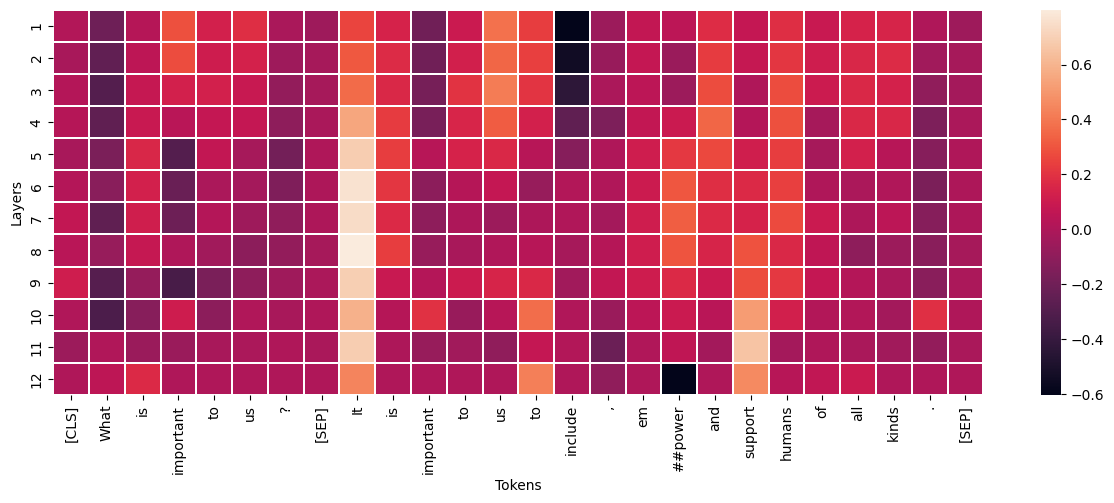

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

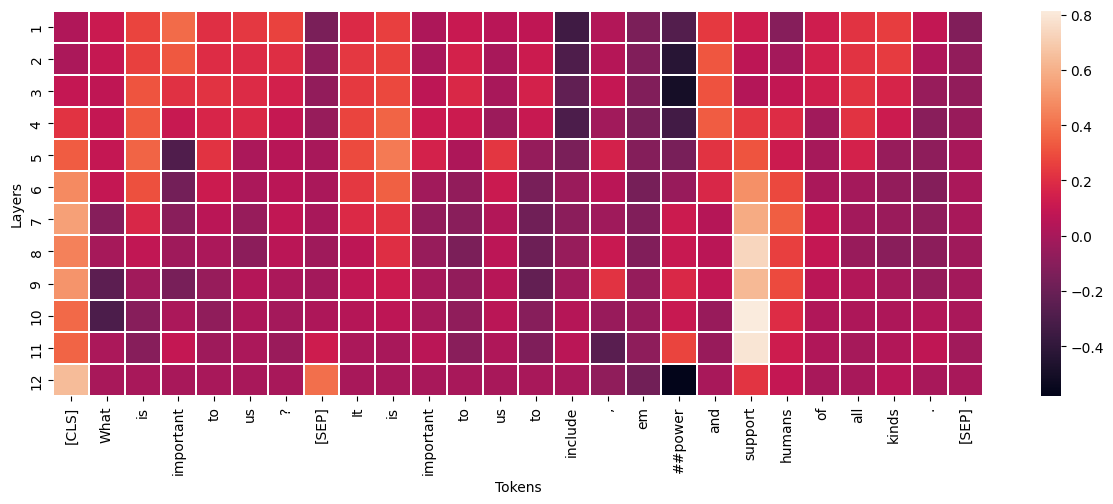

In [41]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

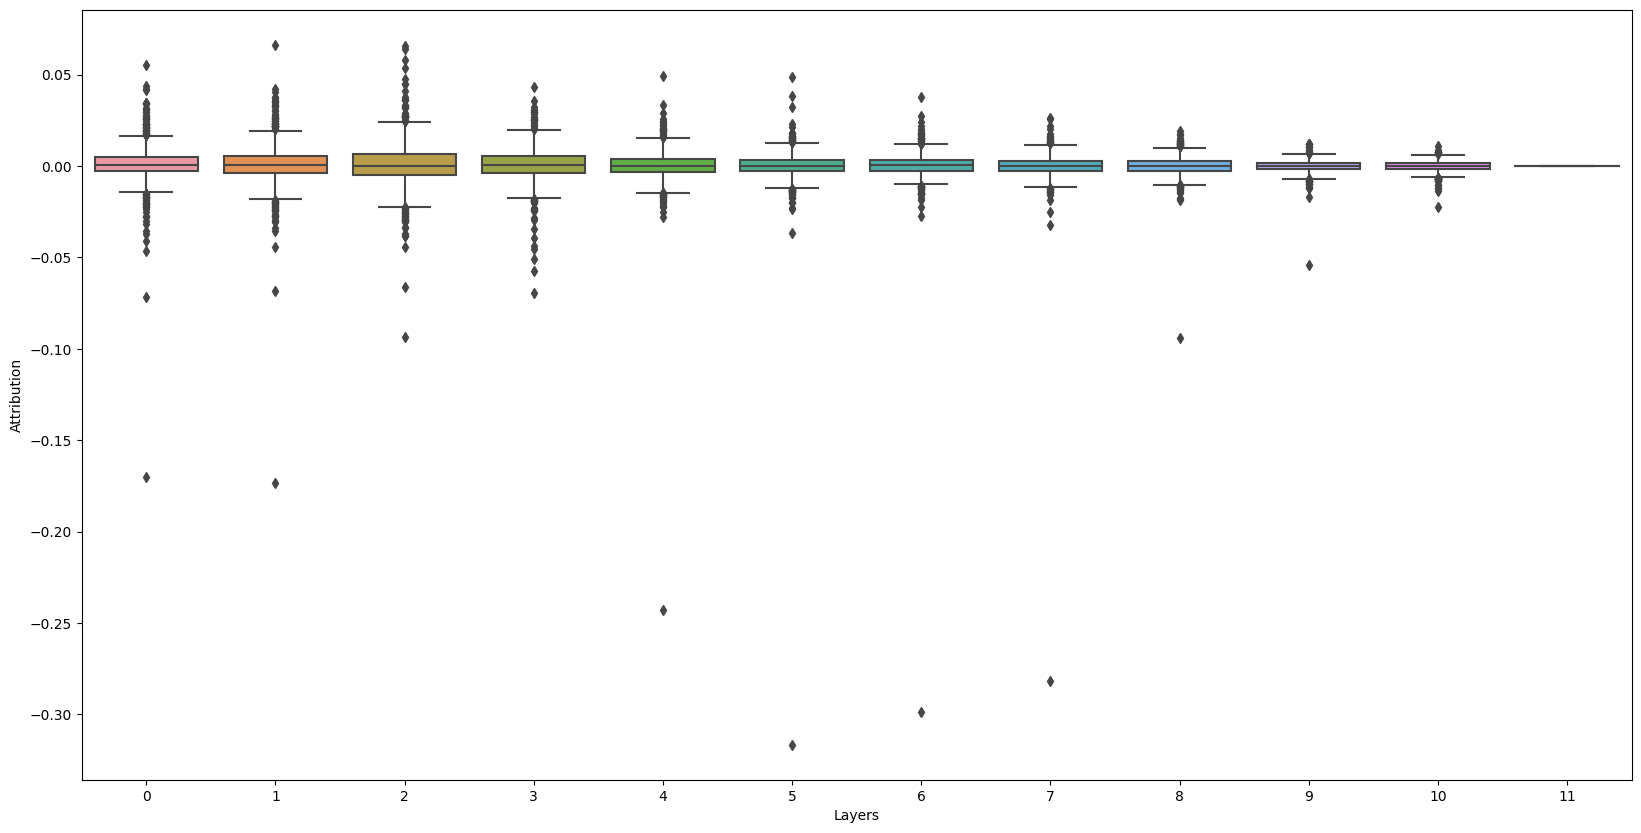

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

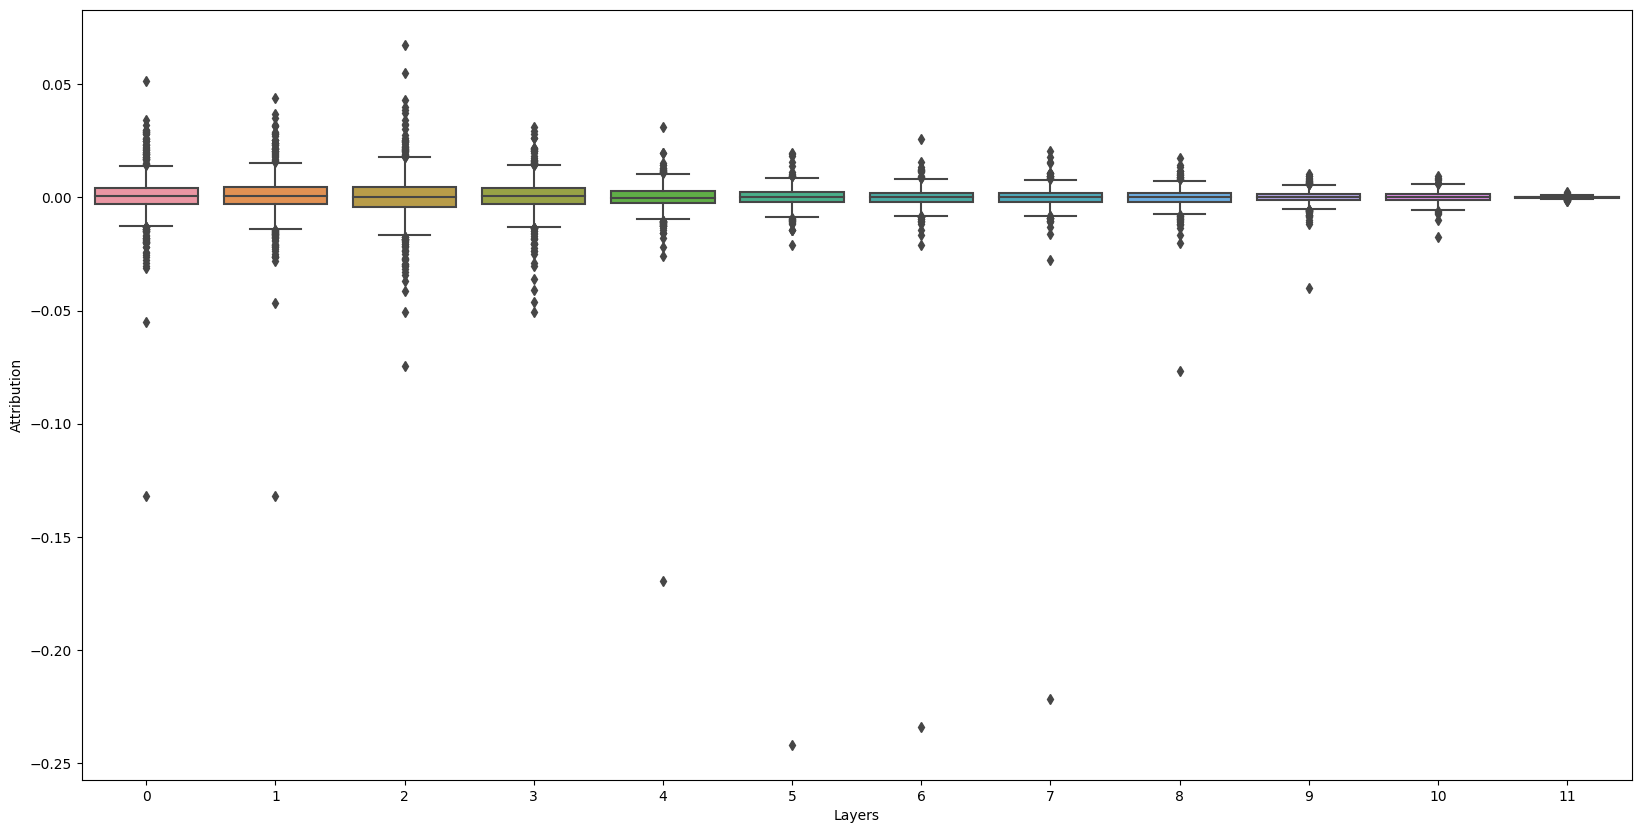

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_end_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [44]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [45]:
layer_attrs_end_pdf = map(lambda layer_attrs_end_dist: pdf_attr(layer_attrs_end_dist), layer_attrs_end_dist)
layer_attrs_end_pdf = np.array(list(layer_attrs_end_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_end_dist).sum(-1)

# size: #layers
layer_attrs_end_pdf_norm = np.linalg.norm(layer_attrs_end_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_end_pdf = np.transpose(layer_attrs_end_pdf)

#size: #bins x #layers
layer_attrs_end_pdf = np.divide(layer_attrs_end_pdf, layer_attrs_end_pdf_norm, where=layer_attrs_end_pdf_norm!=0)

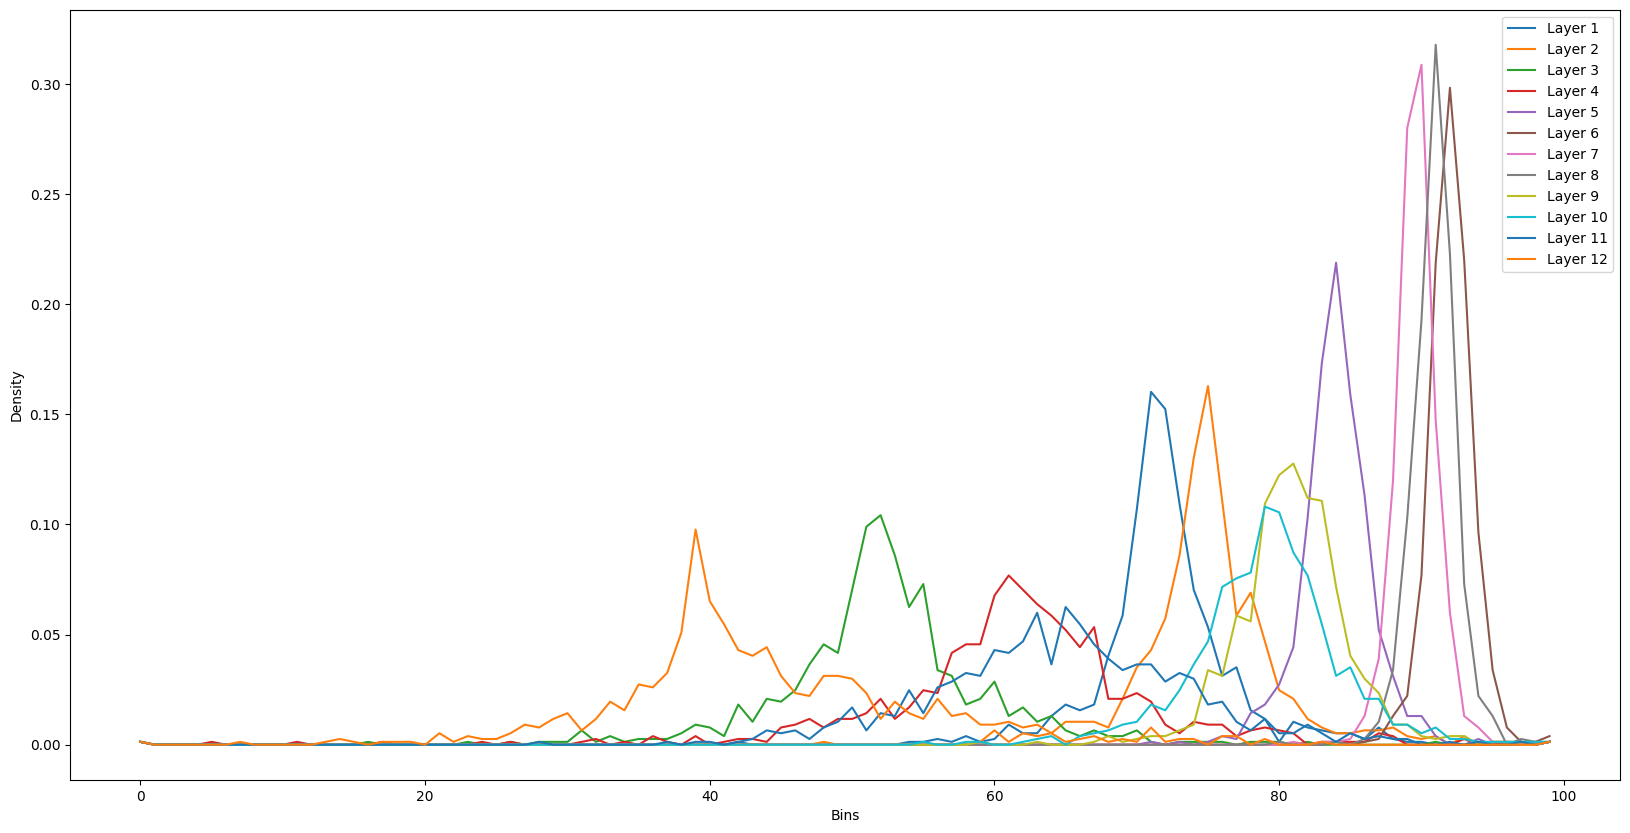

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_end_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

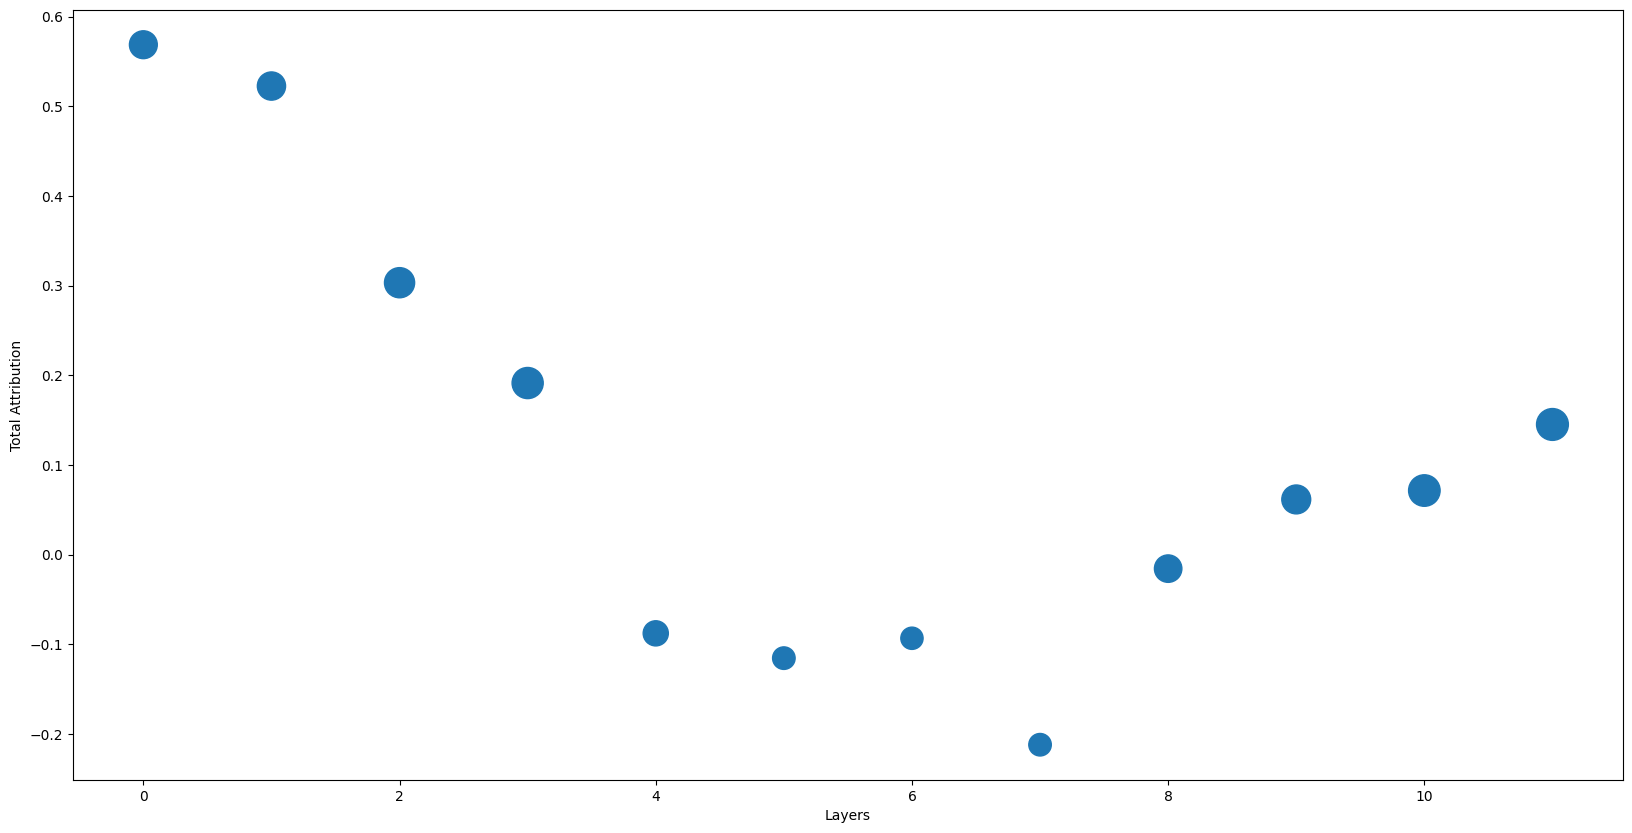

In [47]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_end_pdf[layer_attrs_end_pdf == 0] = 1
layer_attrs_end_pdf_log = np.log2(layer_attrs_end_pdf)

# size: #layers
entropies= -(layer_attrs_end_pdf * layer_attrs_end_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()

# Part 2

In [3]:
# Additional packages not included above

import os

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import IntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Much is repeated from part 1, some small differences

In [5]:
model_name = "deepset/bert-base-cased-squad2"  # Replace with the model identifier from the Model Hub

model = BertForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
model.to(device)
model.eval()
model.zero_grad()

tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits, output.attentions

In [7]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = model(inputs_embeds=inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

In [8]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id

In [9]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)

    return input_embeddings, ref_input_embeddings

In [10]:
question, text = "What is important to us?", "It is important to us to include, empower and support humans of all kinds."

In [11]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [12]:
start_scores, end_scores, output_attentions = predict(input_ids,
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question:  What is important to us?
Predicted Answer:  to include , em ##power and support humans of all kinds


## Visualizing Attention Matrices

In [13]:
# shape -> layer x batch x head x seq_len x seq_len
output_attentions_all = torch.stack(output_attentions)

In [14]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [15]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [16]:
layer = 11

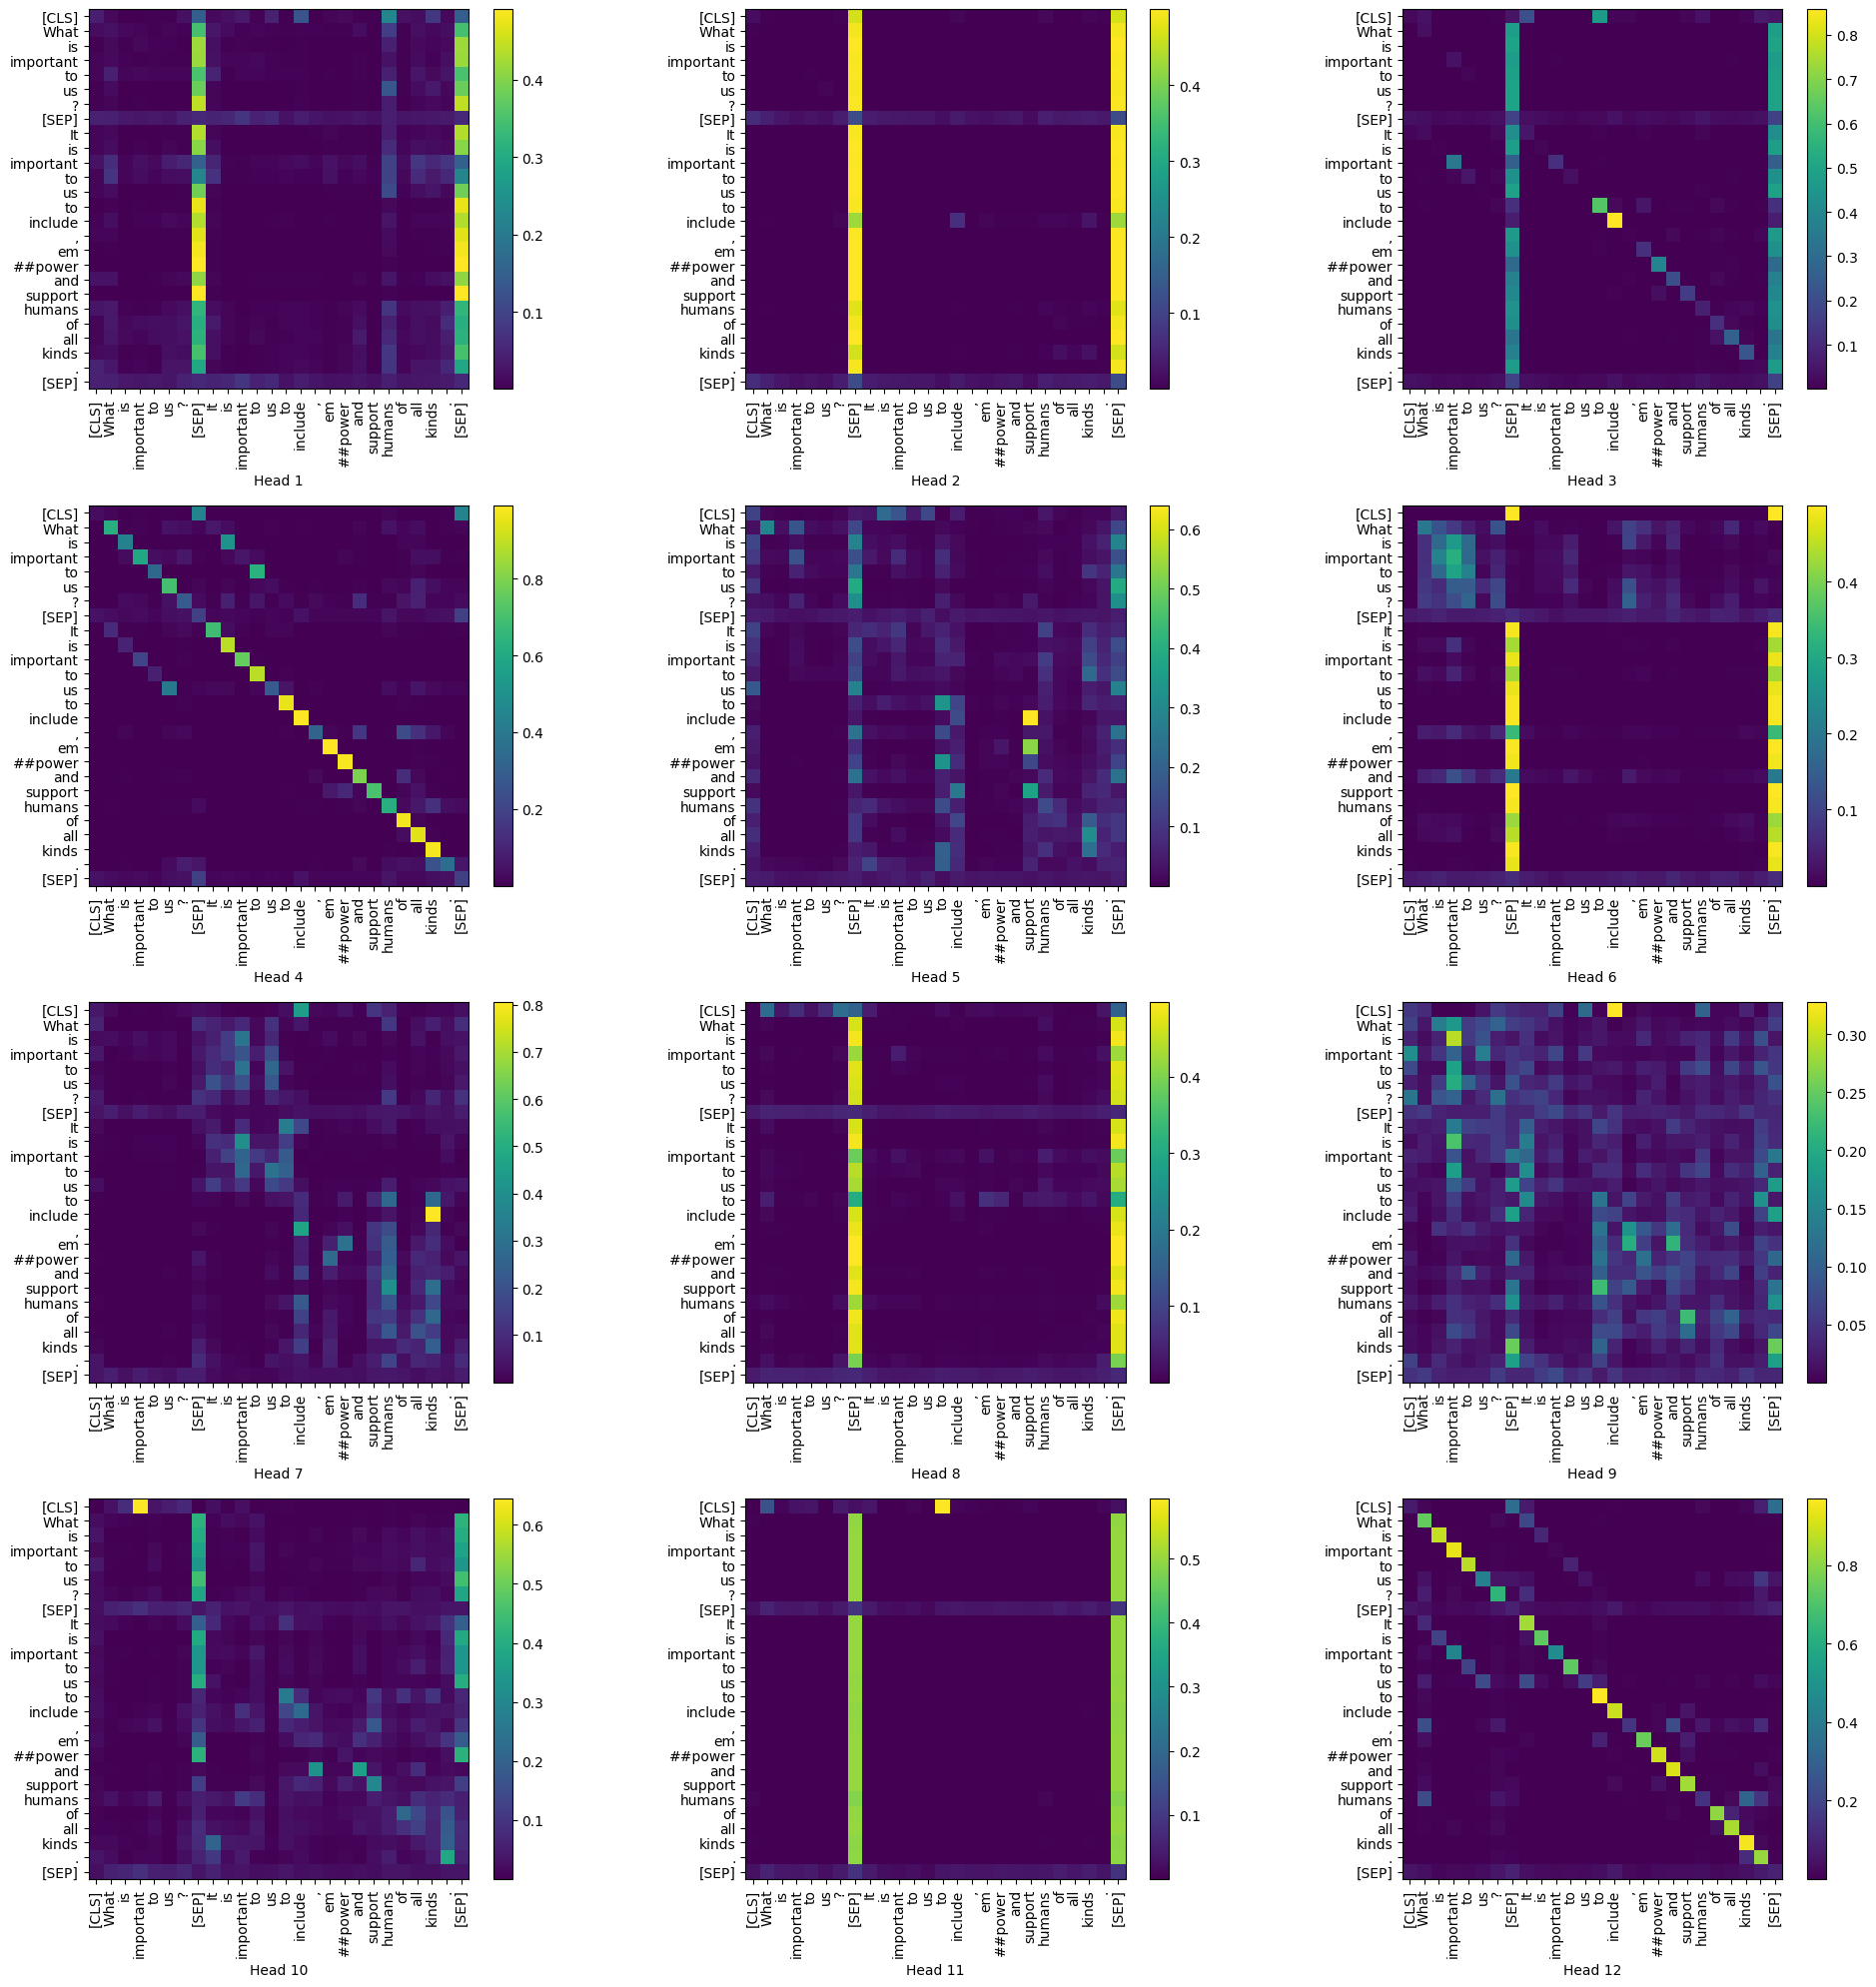

In [17]:
visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy())

In [18]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

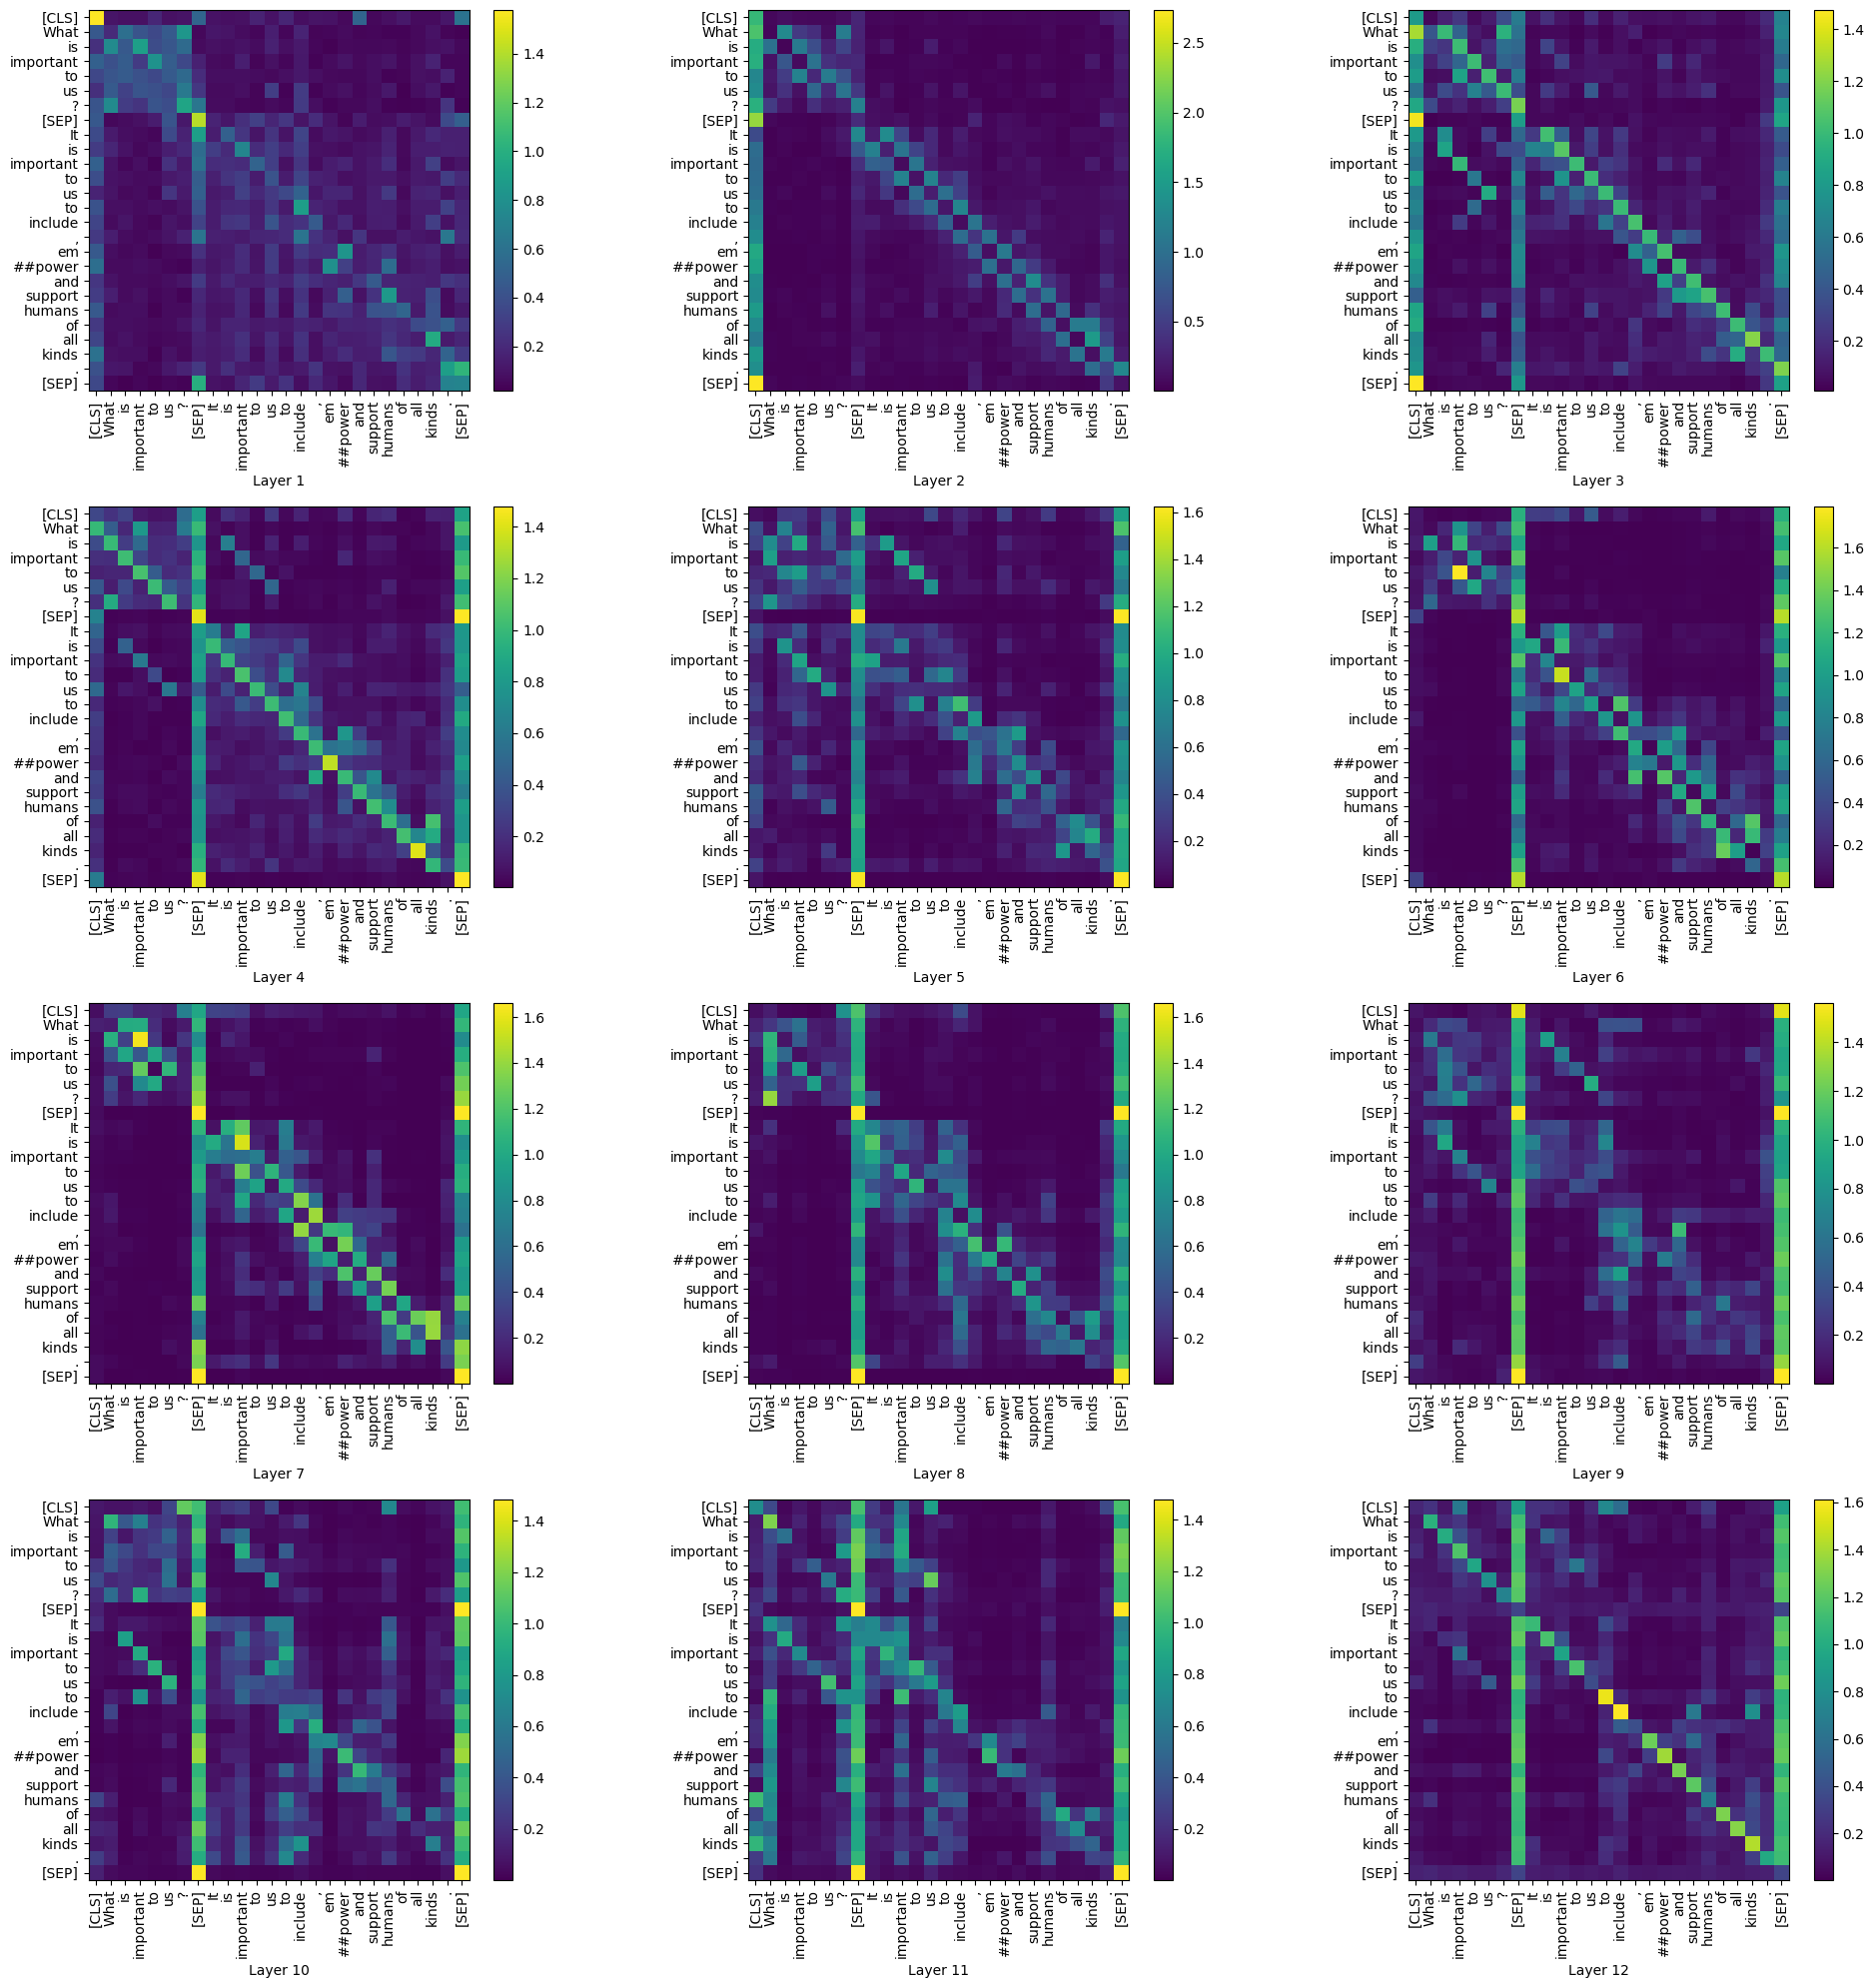

In [19]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

## Visualizing attribution/importance scores

In [20]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

## Interpreting BertLayer Outputs and Self-Attention Matrices in each Layer

In [21]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')

/usr/local/lib/python3.10/dist-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [22]:
layer_attrs_start = []
layer_attrs_end = []

layer_attn_mat_start = []
layer_attn_mat_end = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 1))

    layer_attrs_start.append(summarize_attributions(layer_attributions_start[0]))
    layer_attrs_end.append(summarize_attributions(layer_attributions_end[0]))

    layer_attn_mat_start.append(layer_attributions_start[1])
    layer_attn_mat_end.append(layer_attributions_end[1])

In [23]:
# layer x seq_len
layer_attrs_start = torch.stack(layer_attrs_start)
# layer x seq_len
layer_attrs_end = torch.stack(layer_attrs_end)

# layer x batch x head x seq_len x seq_len
layer_attn_mat_start = torch.stack(layer_attn_mat_start)
# layer x batch x head x seq_len x seq_len
layer_attn_mat_end = torch.stack(layer_attn_mat_end)

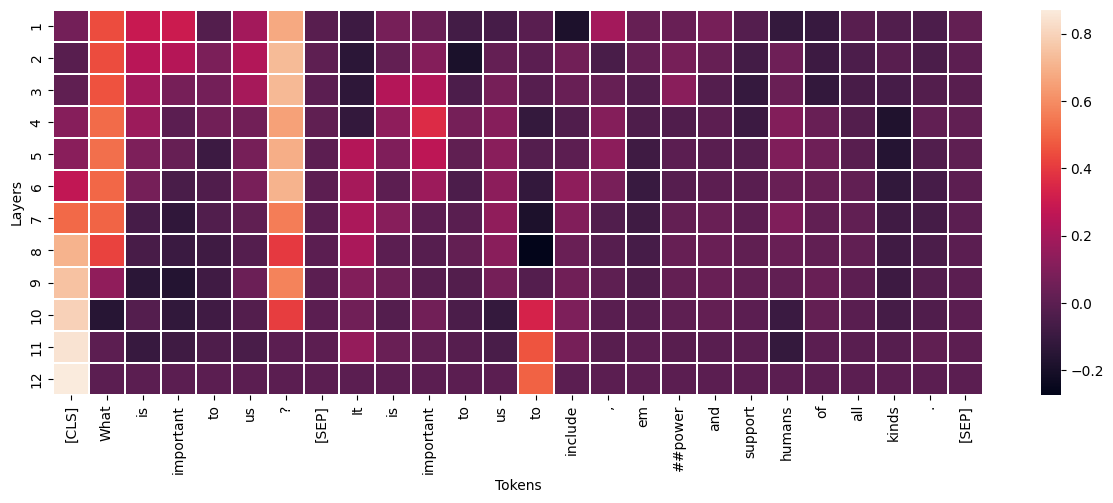

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs_start.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

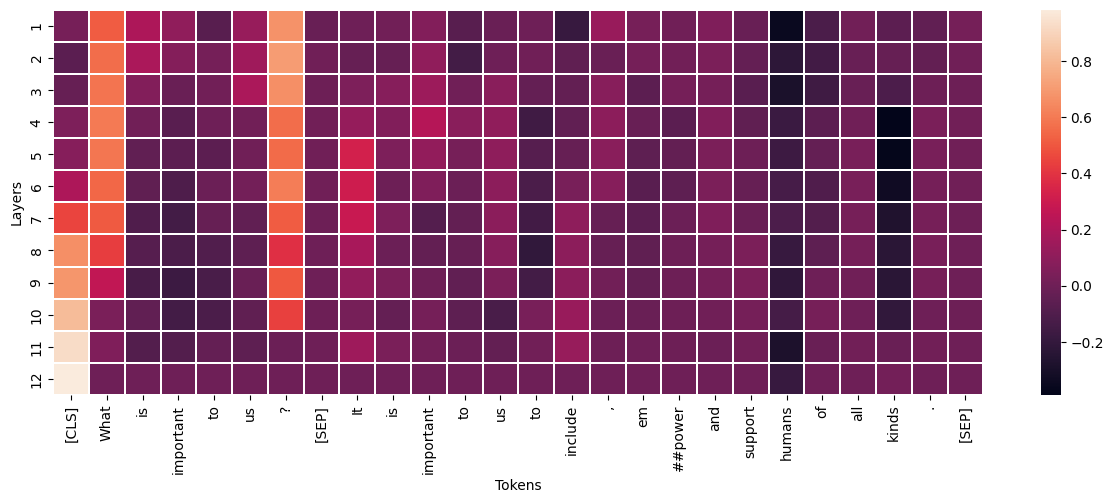

In [25]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs_end.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

## Interpreting Attribution Scores for Attention Matrices

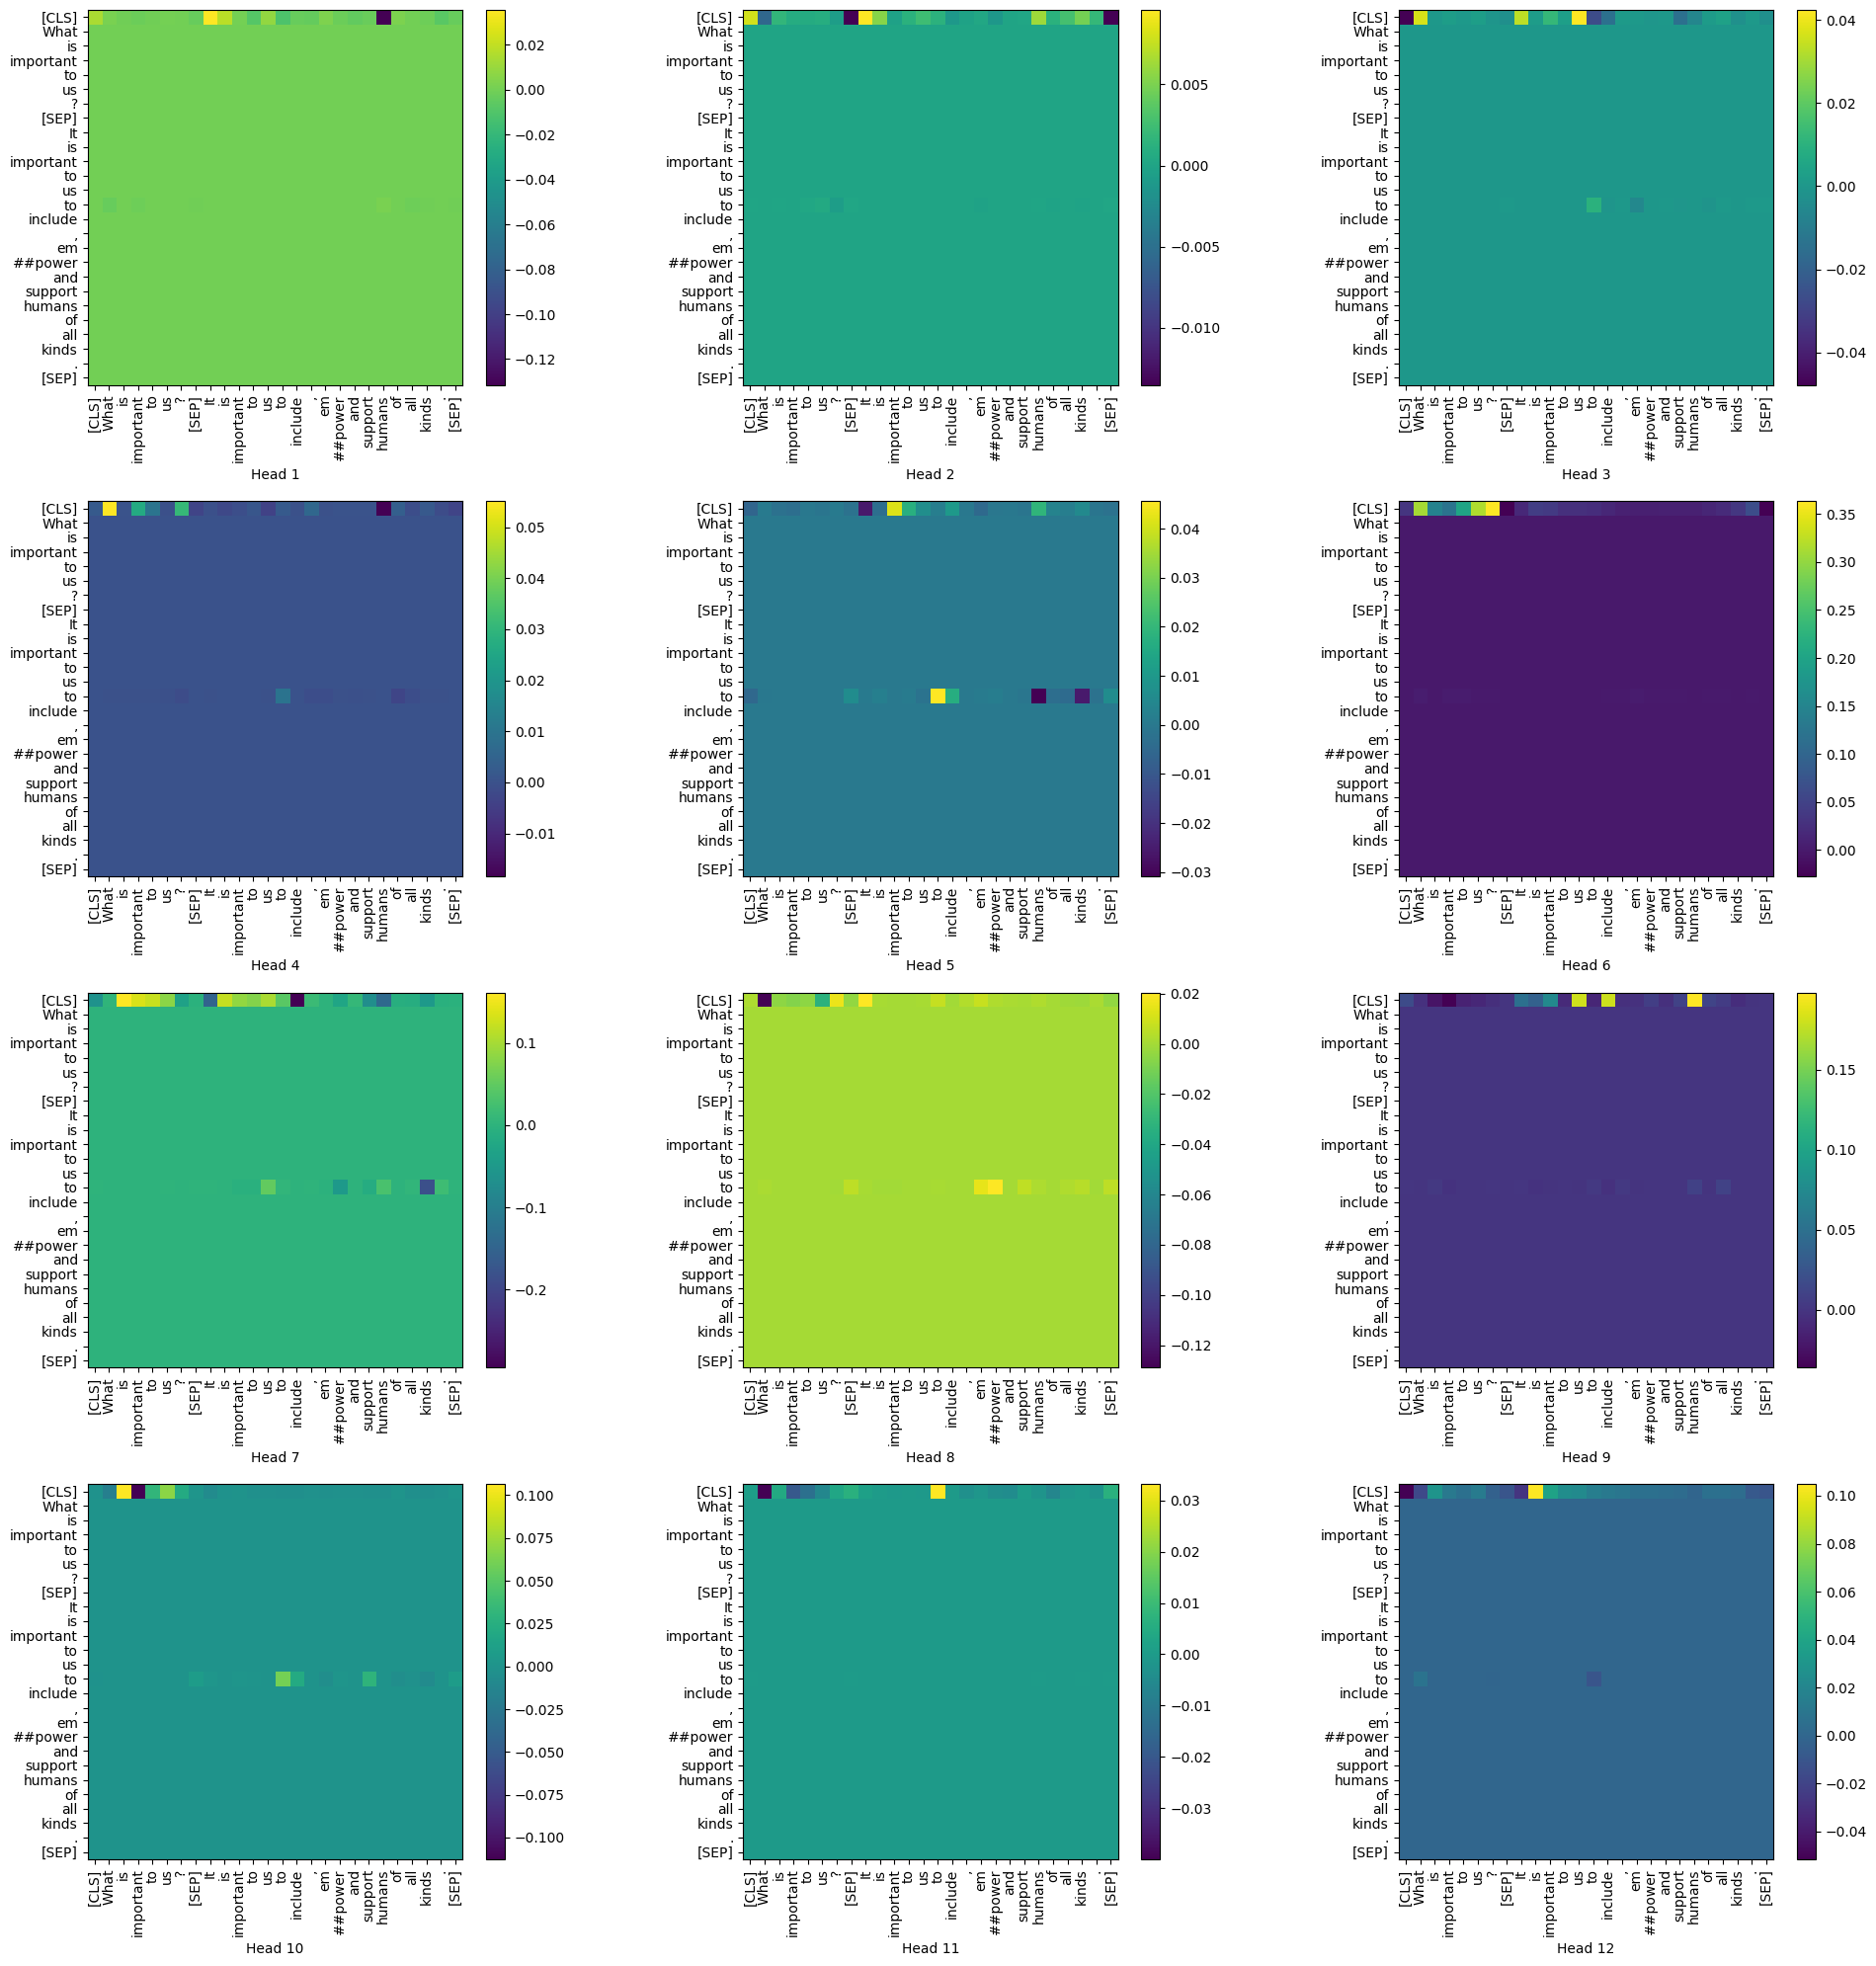

In [26]:
visualize_token2token_scores(layer_attn_mat_start[layer].squeeze().cpu().detach().numpy())

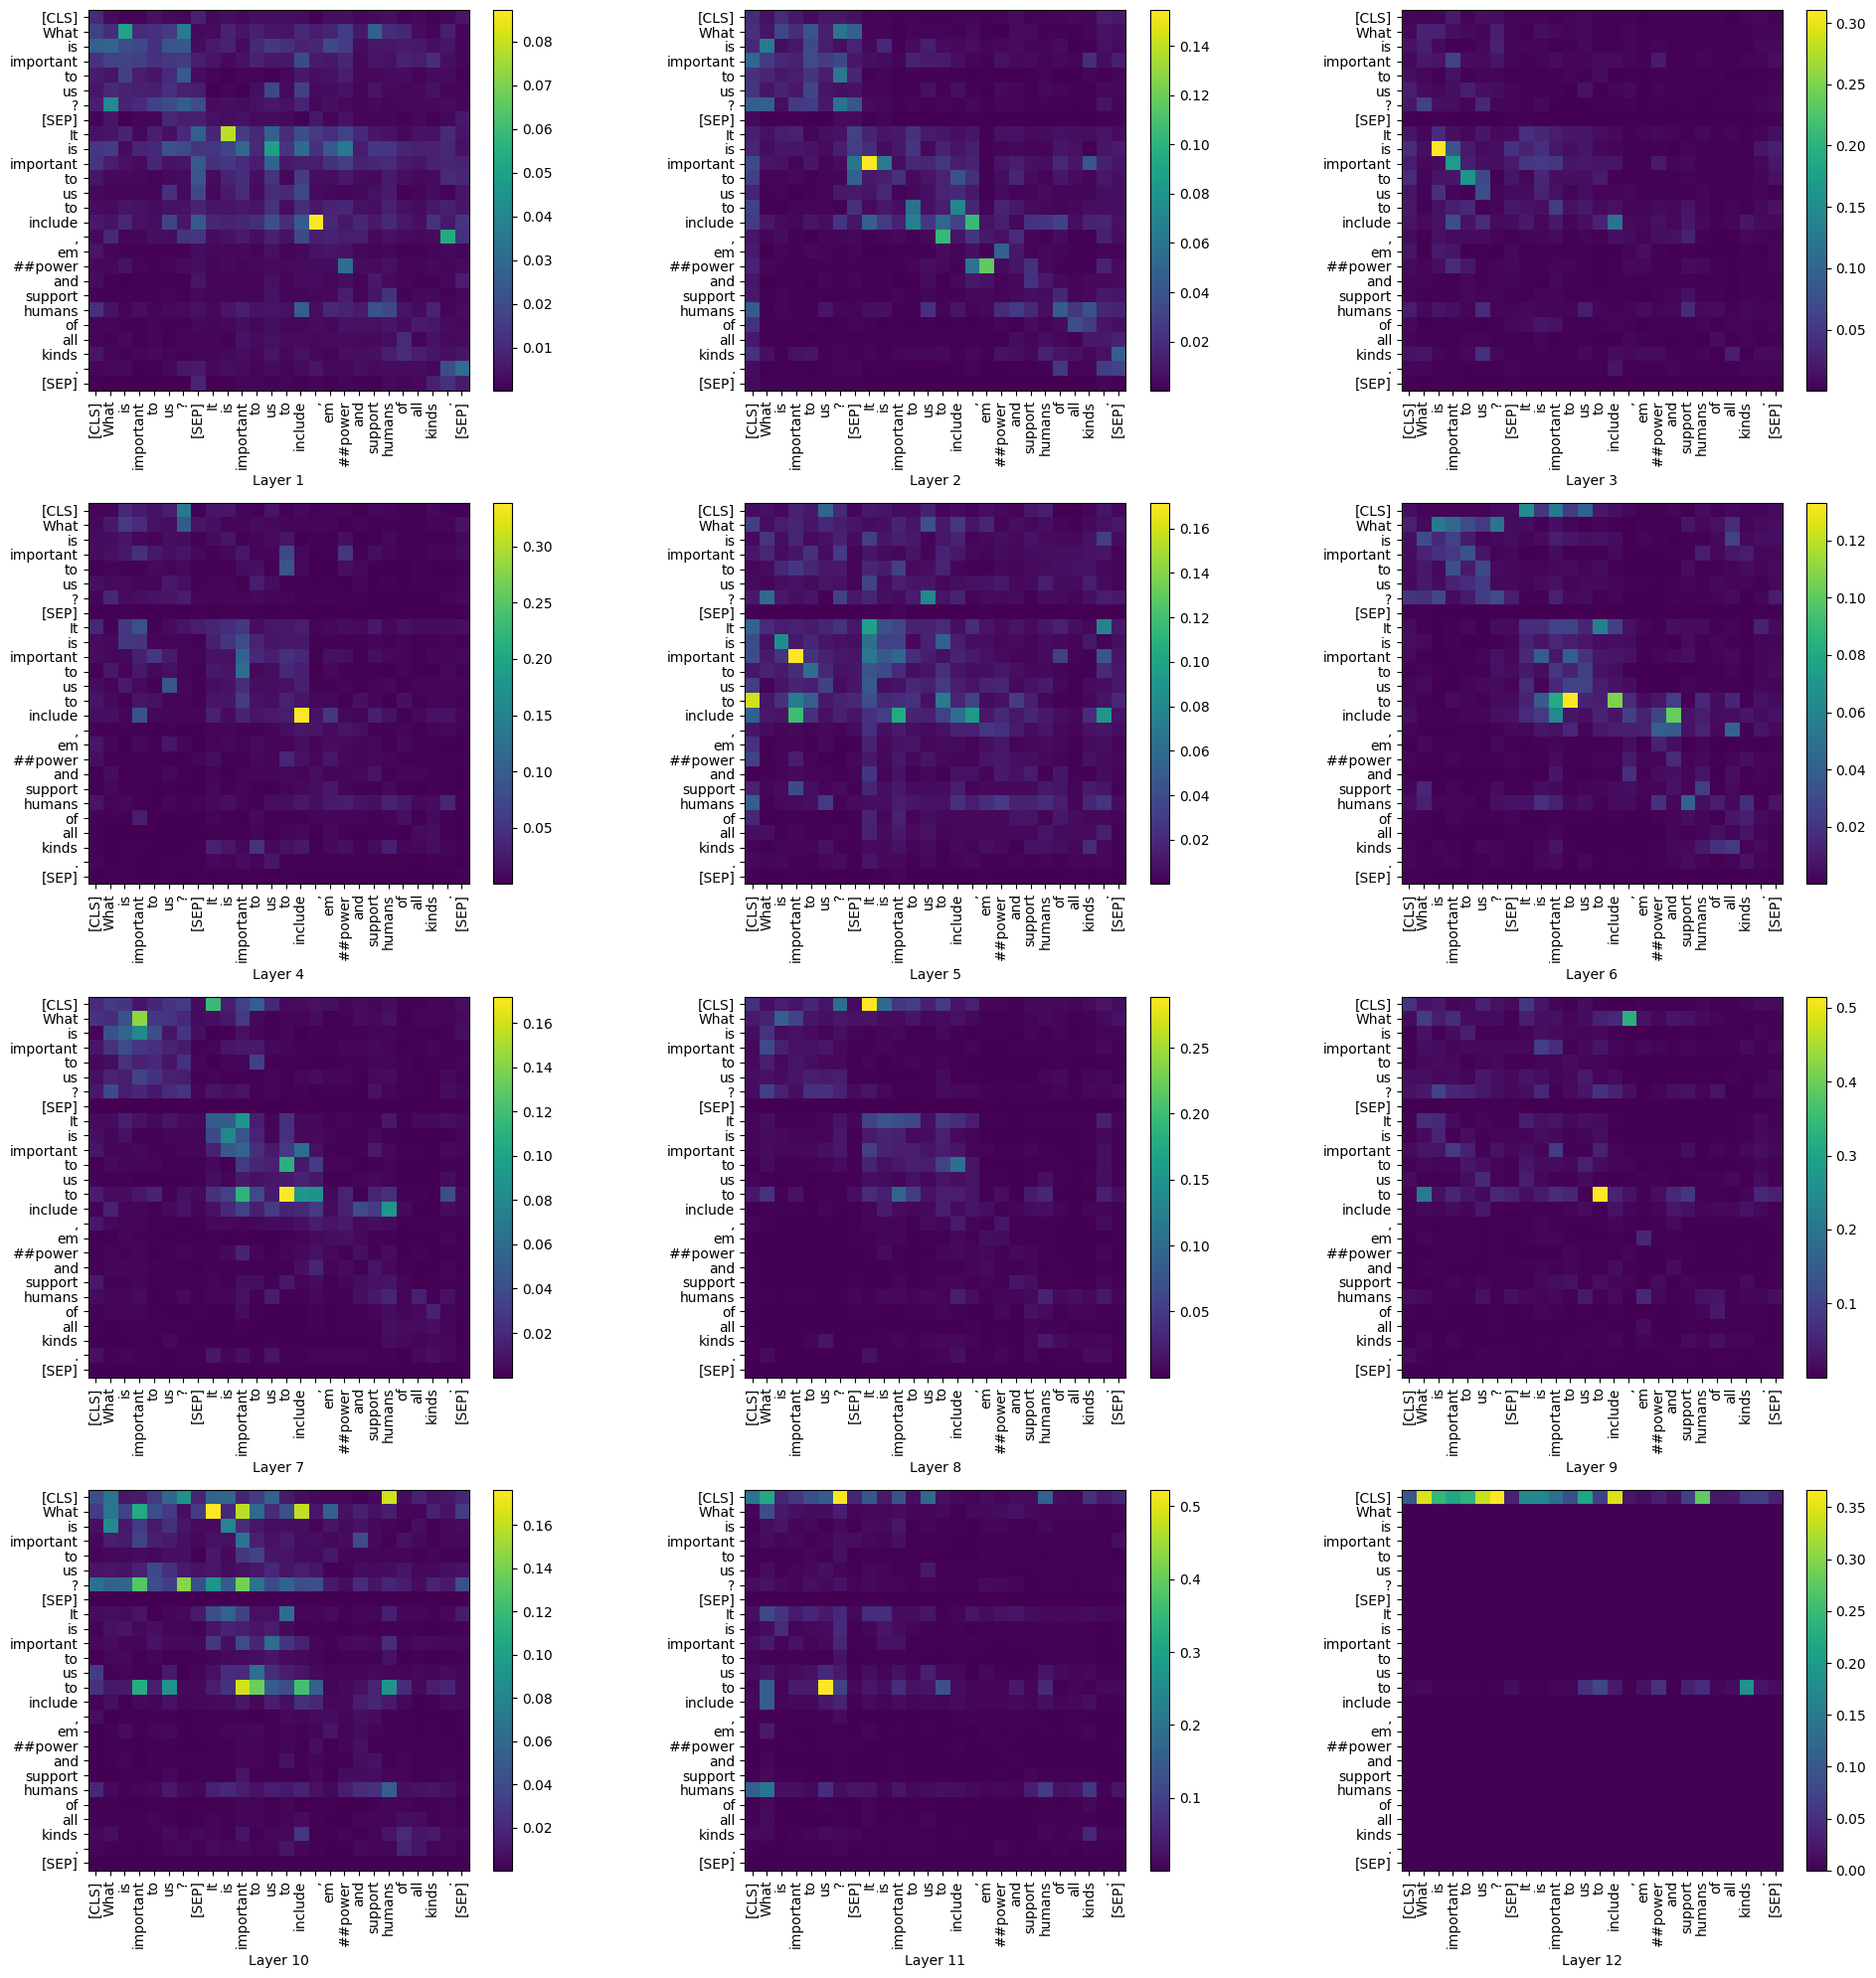

In [27]:
visualize_token2token_scores(norm_fn(layer_attn_mat_start, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

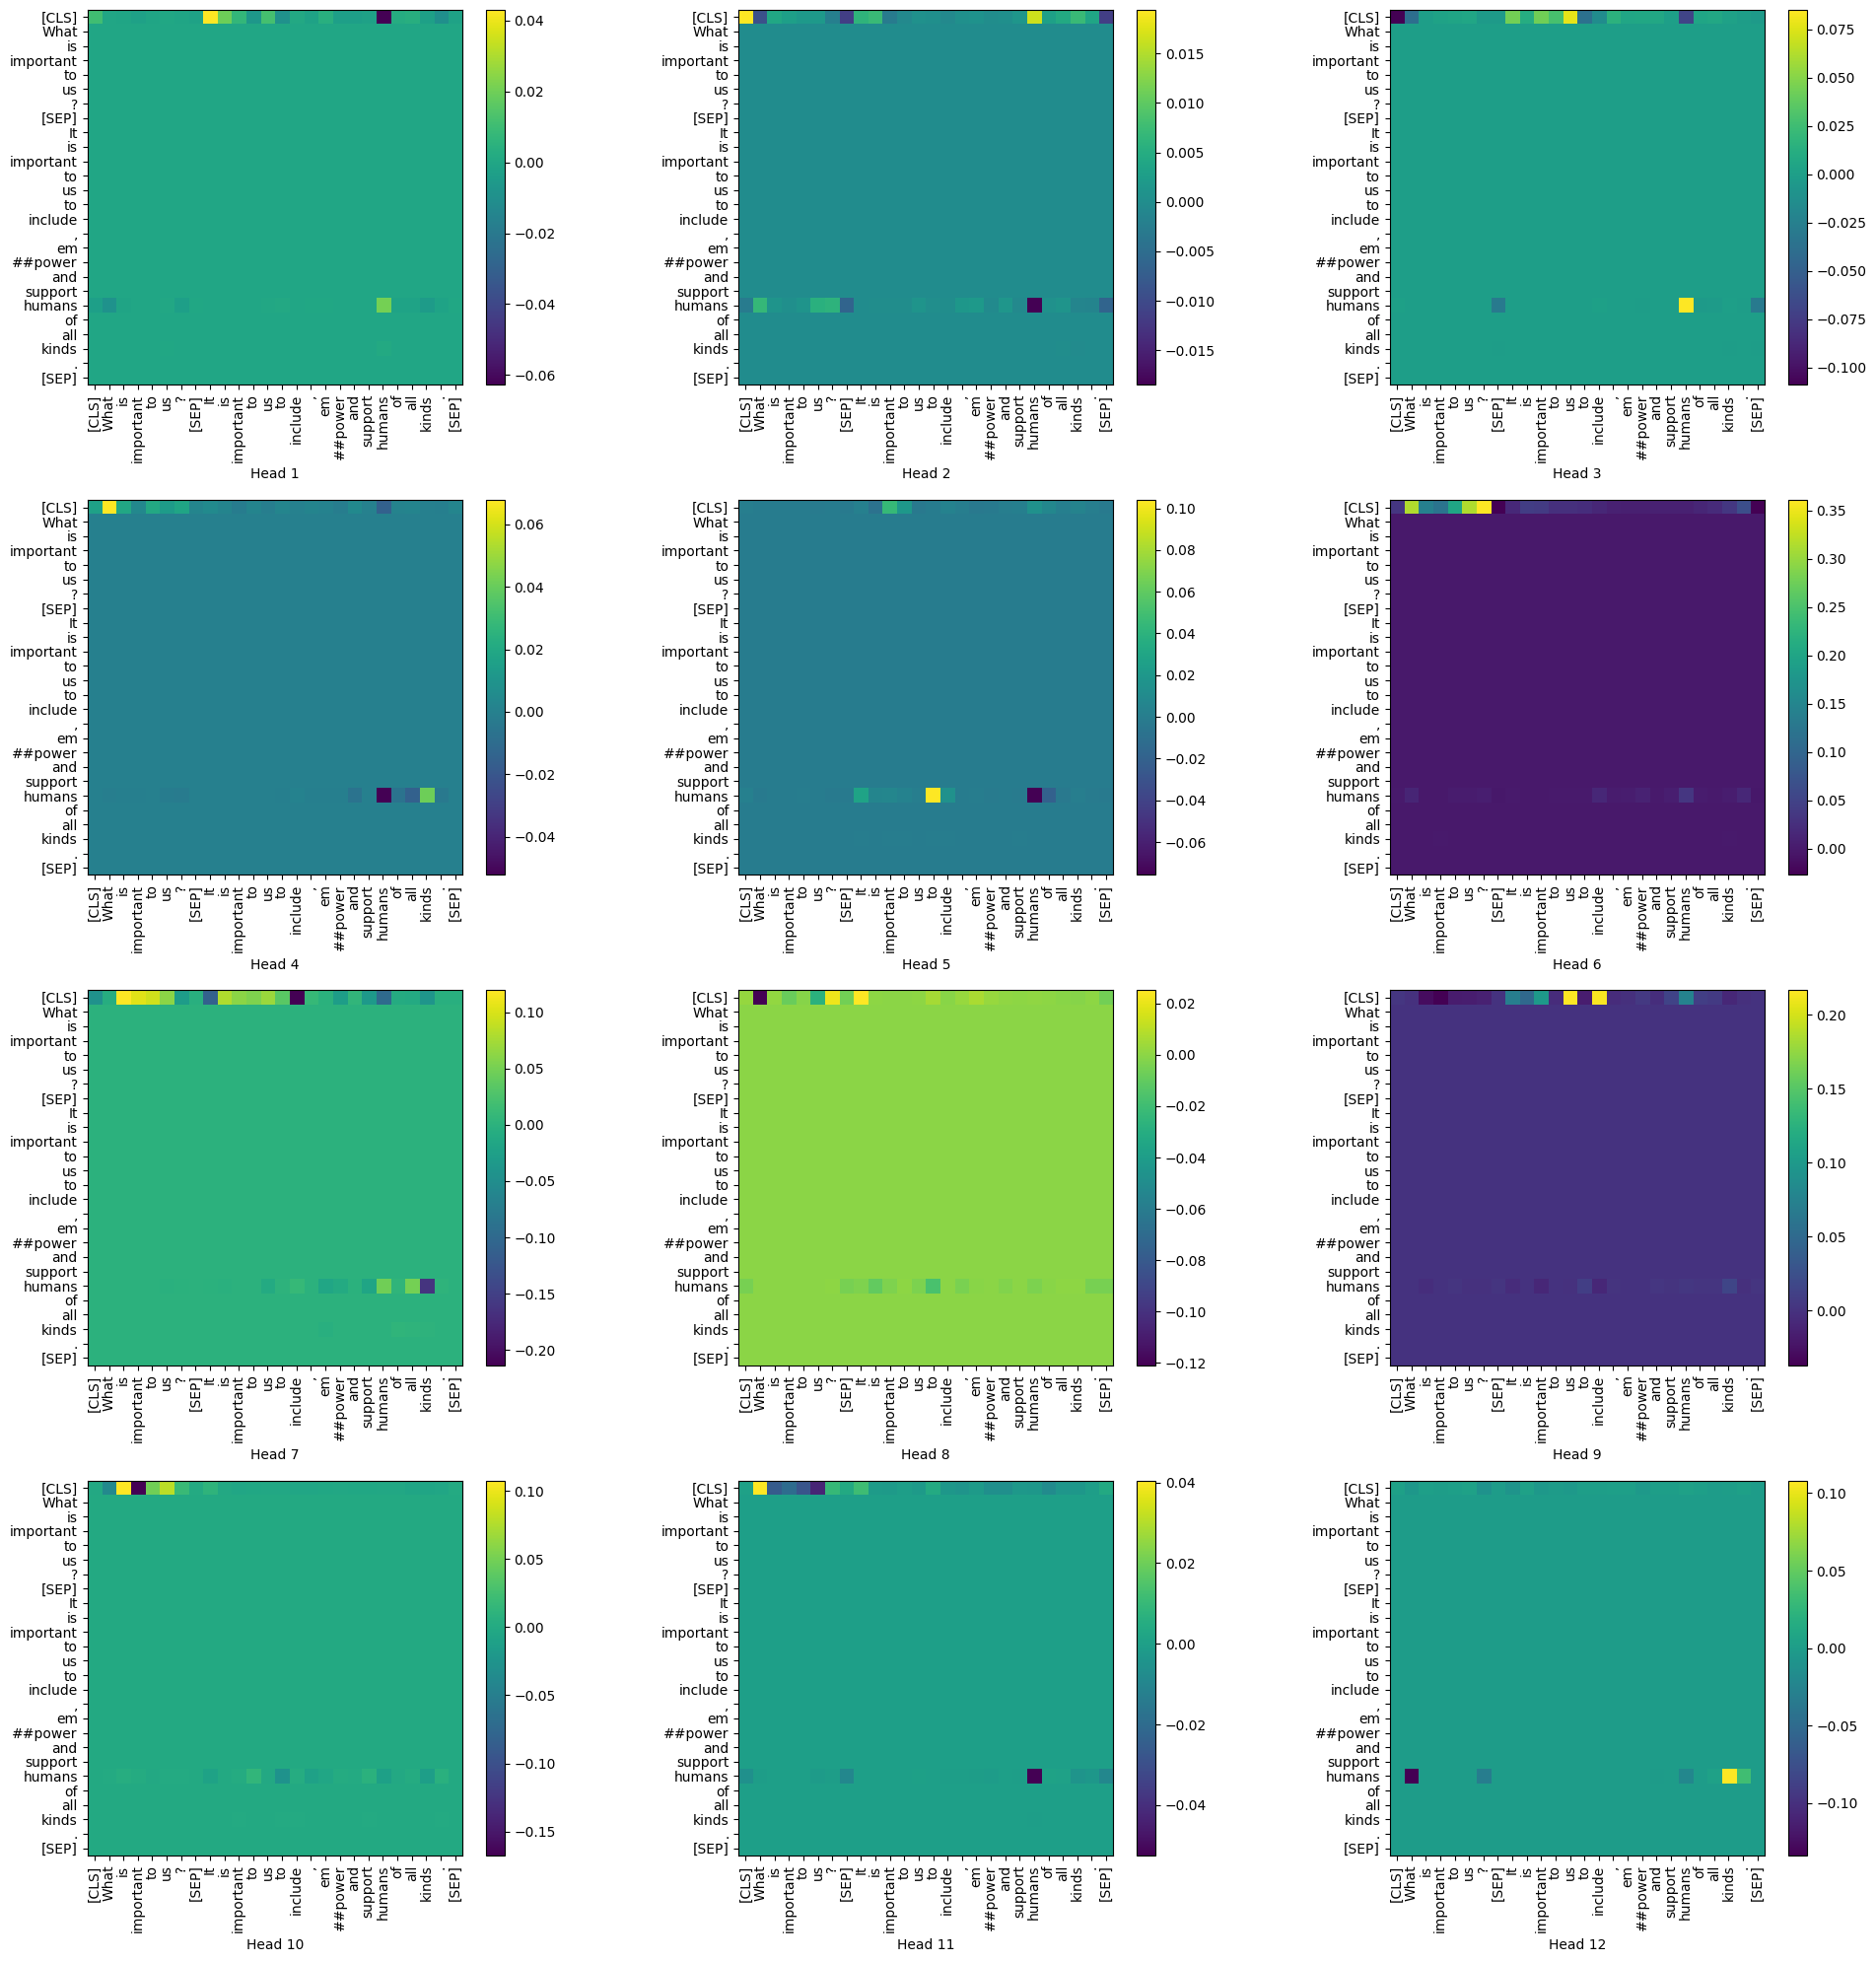

In [28]:
visualize_token2token_scores(layer_attn_mat_end[layer].squeeze().cpu().detach().numpy())

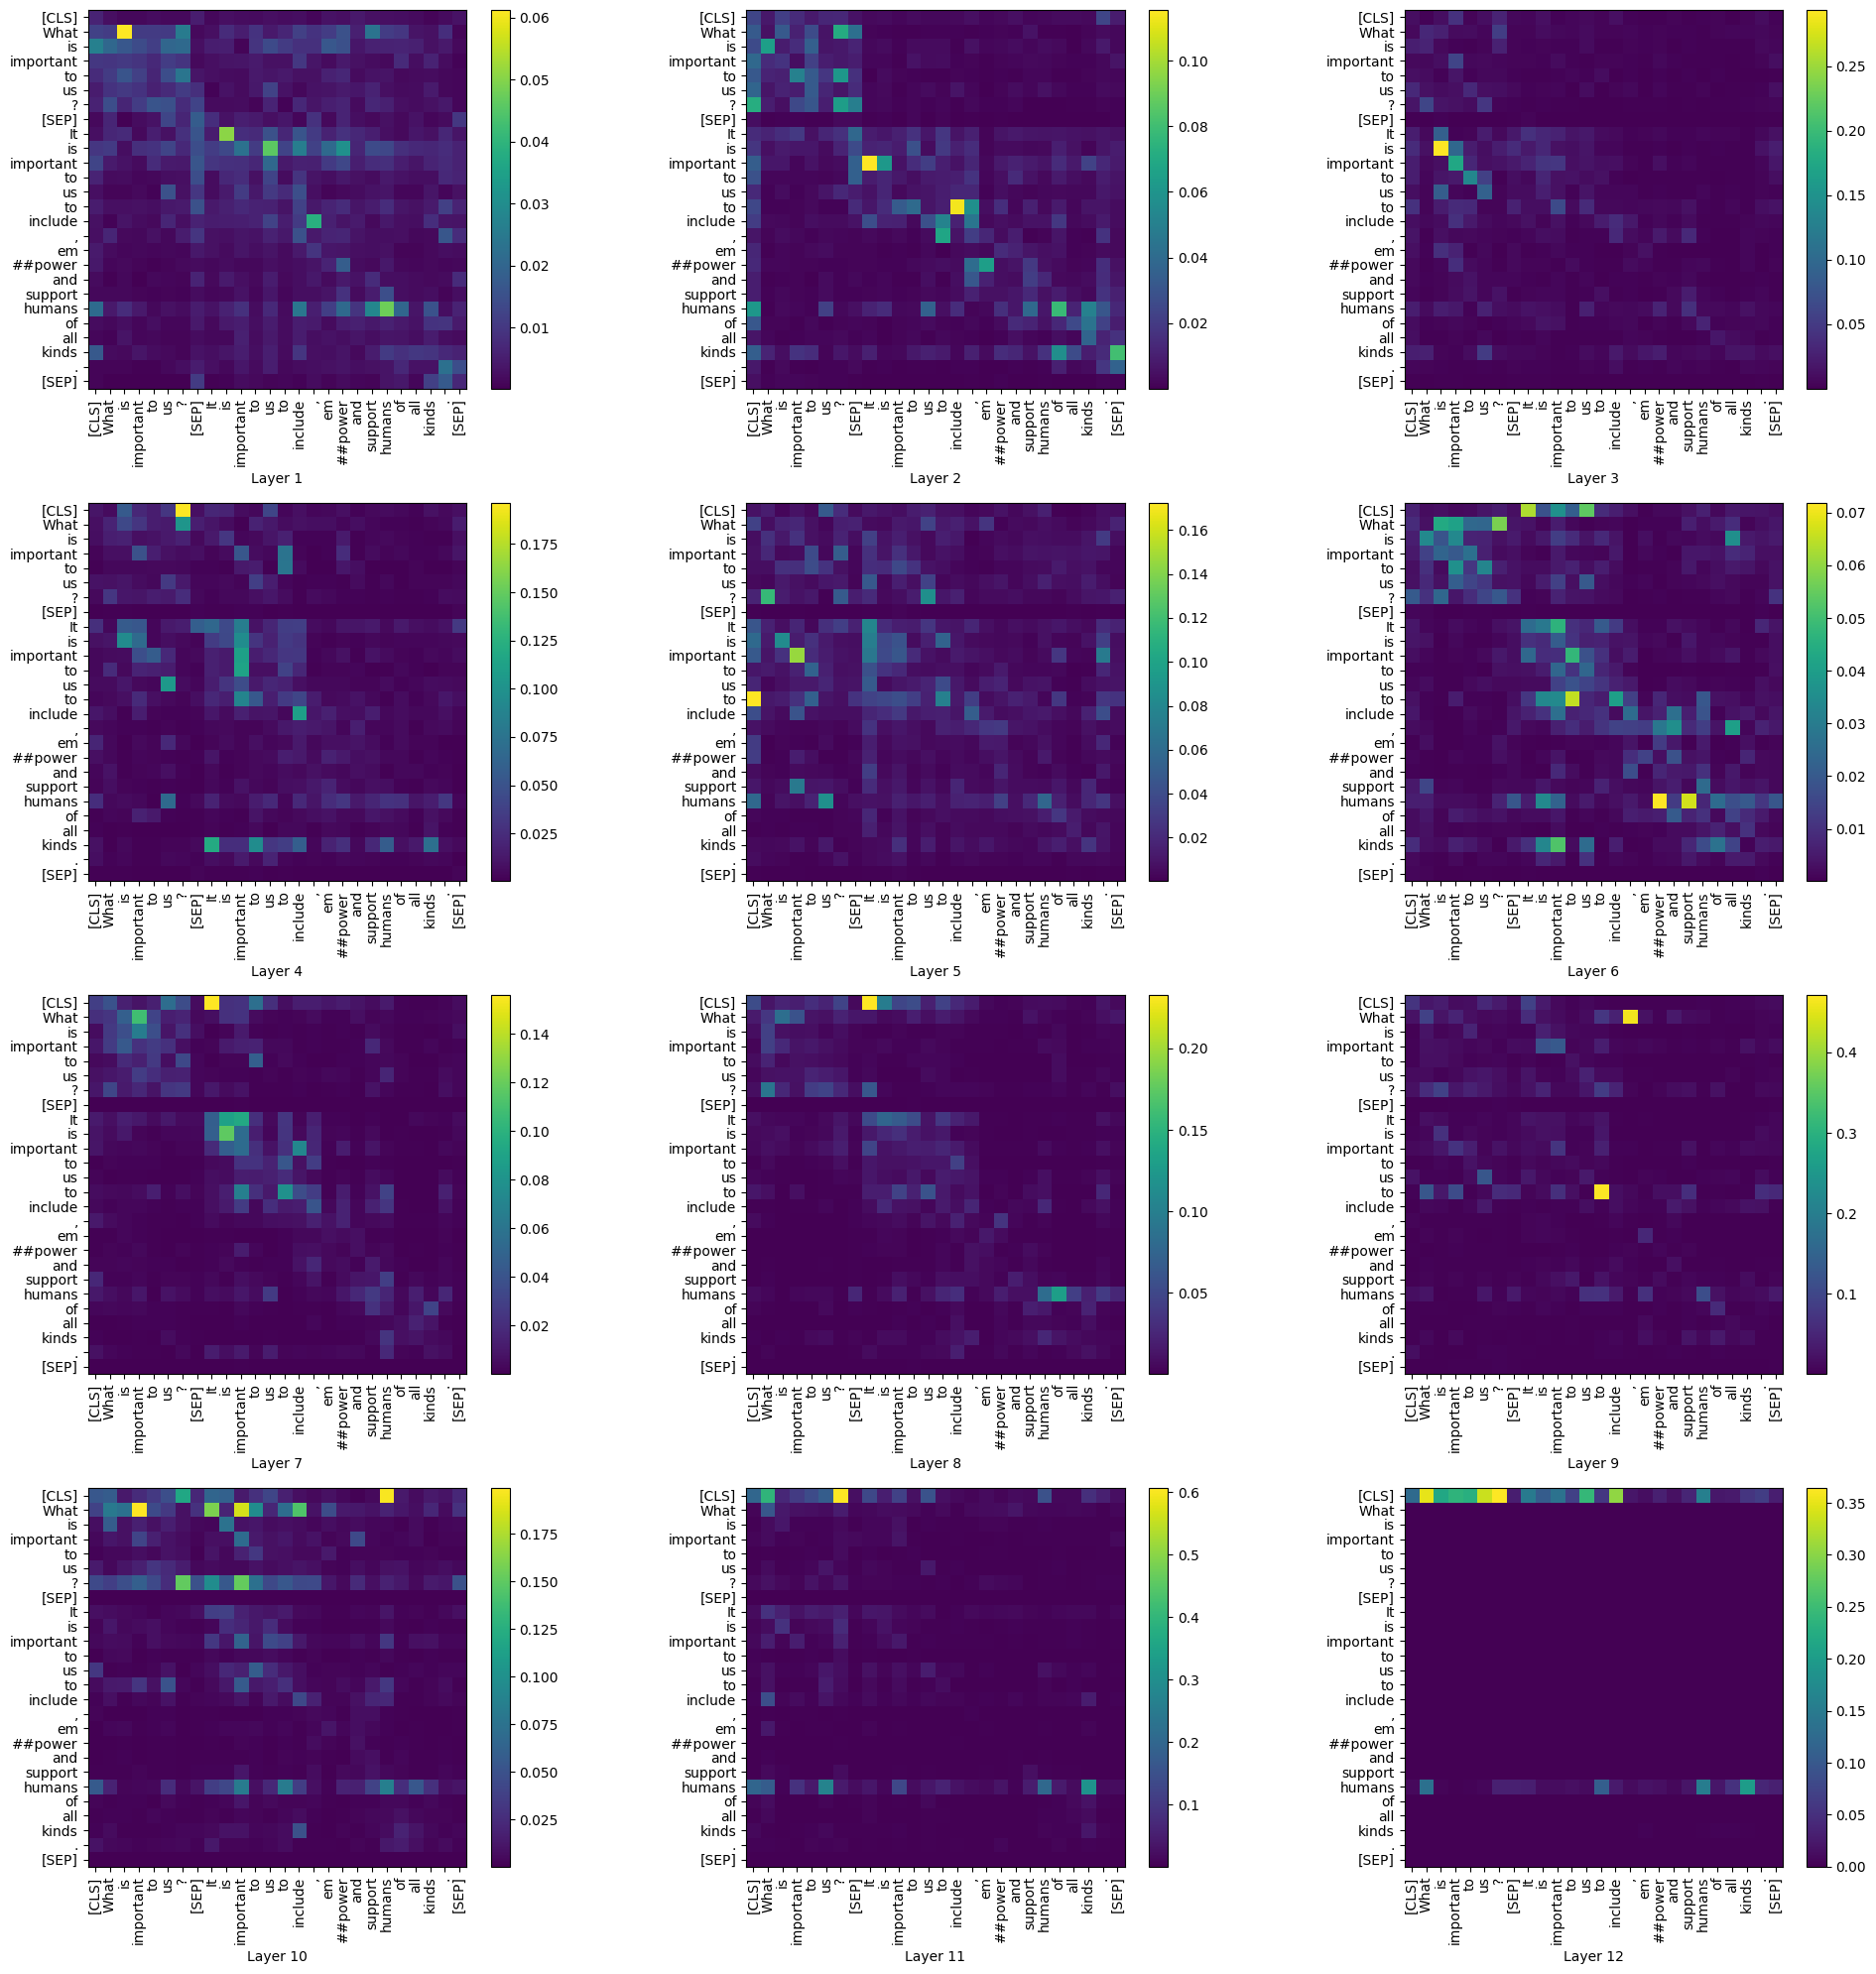

In [29]:
visualize_token2token_scores(norm_fn(layer_attn_mat_end, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

## Computing and Visualizing Vector Norms

In [30]:
output_attentions_all_shape = output_attentions_all.shape

batch = output_attentions_all_shape[1]
num_heads = output_attentions_all_shape[2]
head_size = 64
all_head_size = 768

### Getting Access to Value Activations

In [31]:
layers = [model.bert.encoder.layer[layer].attention.self.value for layer in range(len(model.bert.encoder.layer))]

In [32]:
la = LayerActivation(squad_pos_forward_func, layers)

value_layer_acts = la.attribute(input_embeddings, additional_forward_args=(token_type_ids, position_ids, attention_mask))
# shape -> layer x batch x seq_len x all_head_size
value_layer_acts = torch.stack(value_layer_acts)

In [33]:
new_x_shape = value_layer_acts.size()[:-1] + (num_heads, head_size)
value_layer_acts = value_layer_acts.view(*new_x_shape)

# layer x batch x neum_heads x 1 x head_size
value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4)

value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4).contiguous()
value_layer_acts_shape = value_layer_acts.size()

# layer x batch x seq_length x num_heads x 1 x head_size
value_layer_acts = value_layer_acts.view(value_layer_acts_shape[:-1] + (1, value_layer_acts_shape[-1],))

print('value_layer_acts: ', value_layer_acts.shape)

value_layer_acts:  torch.Size([12, 1, 26, 12, 1, 64])


### Getting Access to Dense Features

In [34]:
dense_acts = torch.stack([dlayer.attention.output.dense.weight for dlayer in model.bert.encoder.layer])

dense_acts = dense_acts.view(len(layers), all_head_size, num_heads, head_size)

# layer x num_heads x head_size x all_head_size
dense_acts = dense_acts.permute(0, 2, 3, 1).contiguous()

In [35]:
# layers, batch, seq_length, num_heads, 1, all_head_size
f_x = torch.stack([value_layer_acts_i.matmul(dense_acts_i) for value_layer_acts_i, dense_acts_i in zip(value_layer_acts, dense_acts)])
f_x.shape

torch.Size([12, 1, 26, 12, 1, 768])

In [36]:
# layer x batch x seq_length x num_heads x 1 x all_head_size)
f_x_shape = f_x.size()
f_x = f_x.view(f_x_shape[:-2] + (f_x_shape[-1],))
f_x = f_x.permute(0, 1, 3, 2, 4).contiguous()

#(layers x batch, num_heads, seq_length, all_head_size)
f_x_shape = f_x.size()

#(layers x batch, num_heads, seq_length)
f_x_norm = norm_fn(f_x, dim=-1)

ValueError: ignored

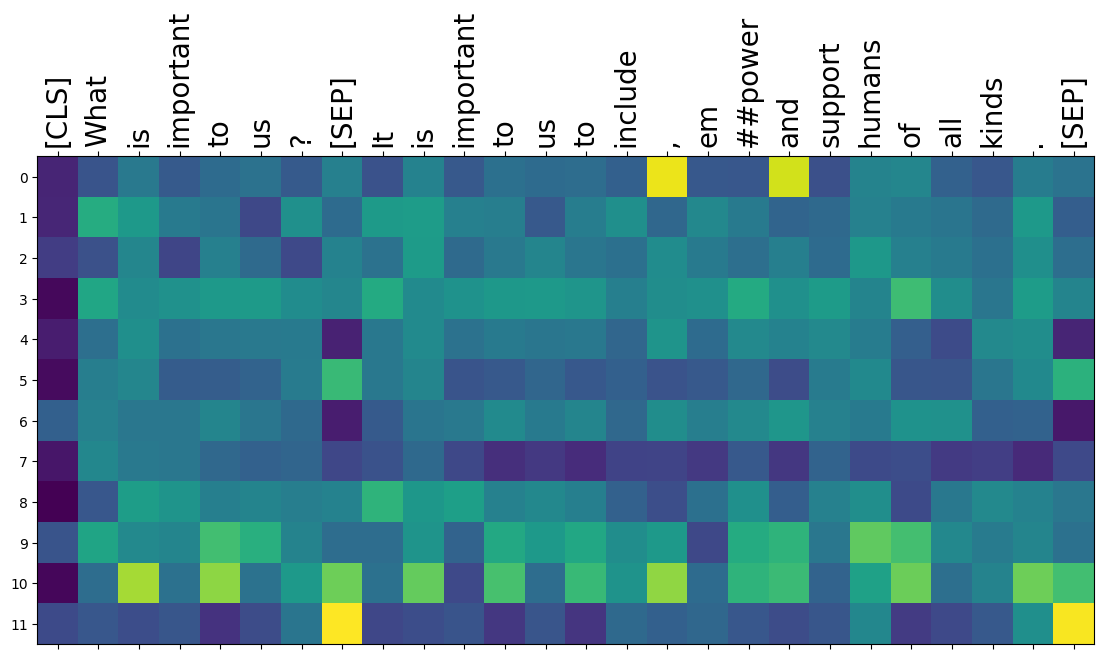

In [37]:
visualize_token2head_scores(f_x_norm.squeeze().detach().cpu().numpy())


In [38]:
# layer x batch x num_heads x seq_length x seq_length x all_head_size
alpha_f_x = torch.einsum('lbhks,lbhsd->lbhksd', output_attentions_all, f_x)

# layer x batch x num_heads x seq_length x seq_length
alpha_f_x_norm = norm_fn(alpha_f_x, dim=-1)

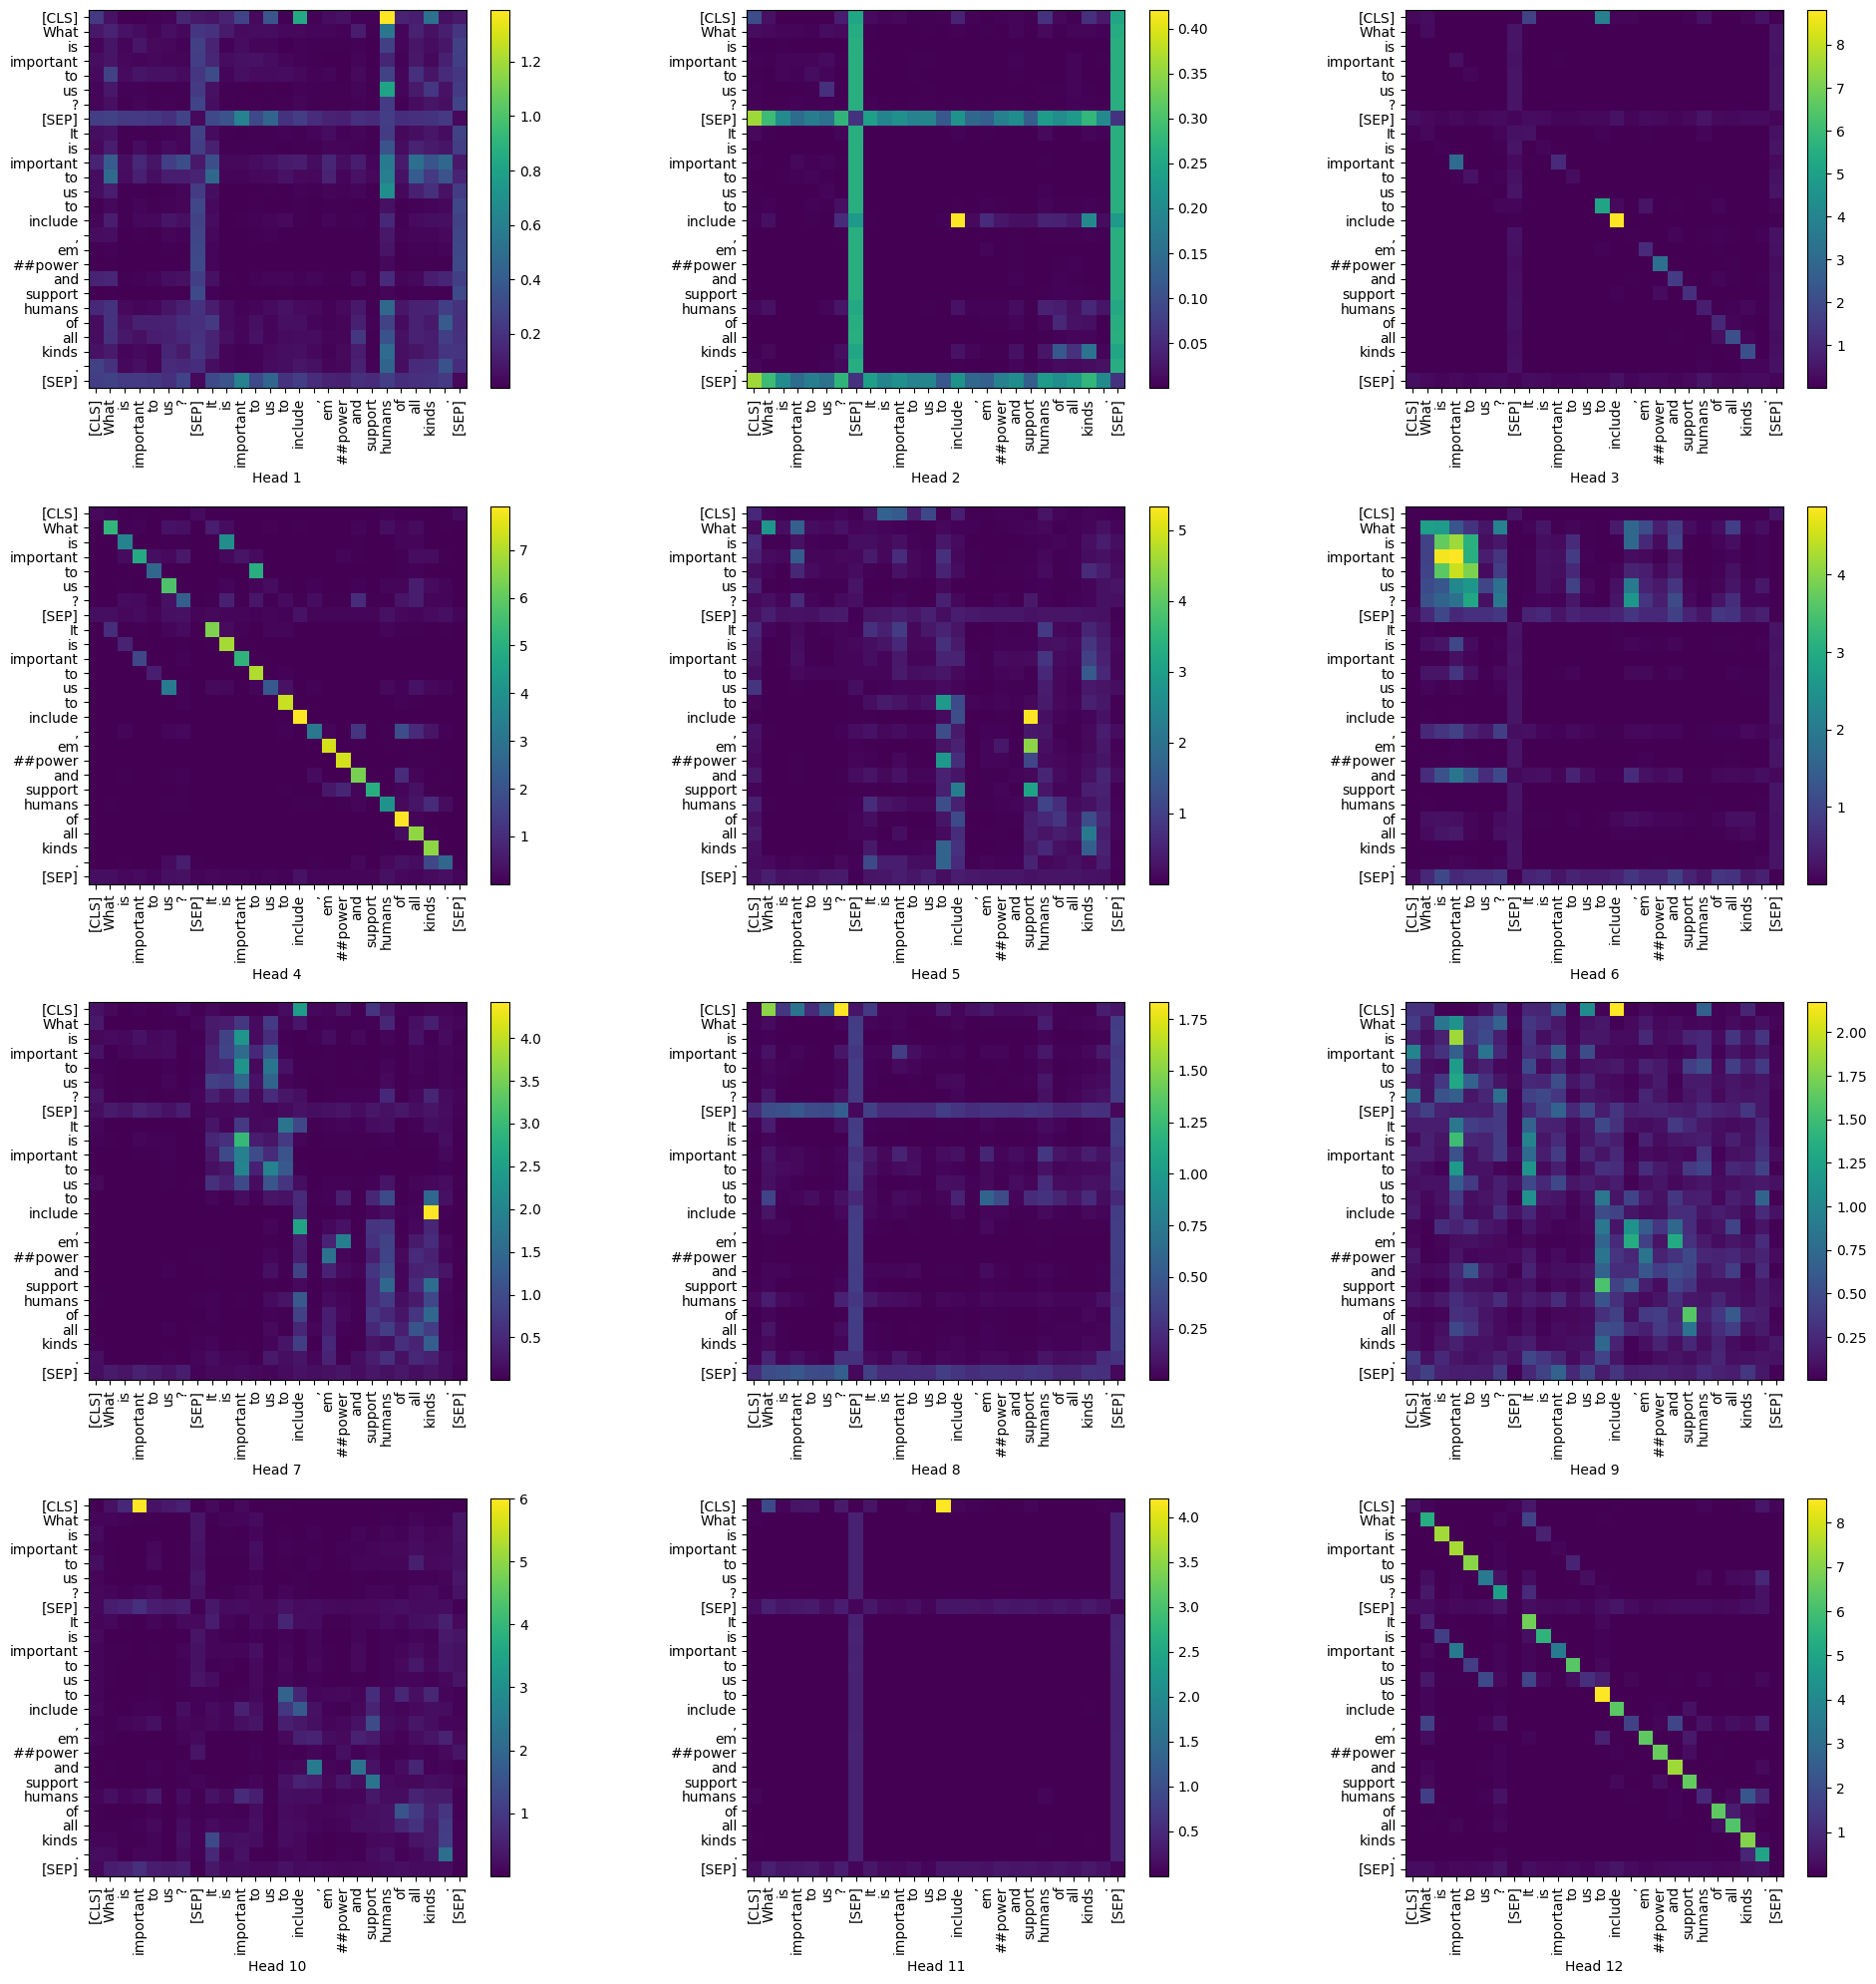

In [39]:
visualize_token2token_scores(alpha_f_x_norm[layer].squeeze().detach().cpu().numpy())

In [40]:
summed_alpha_f_x = alpha_f_x.sum(dim=2)

# layers x batch x seq_length x seq_length
summed_alpha_f_x_norm = norm_fn(summed_alpha_f_x, dim=-1)

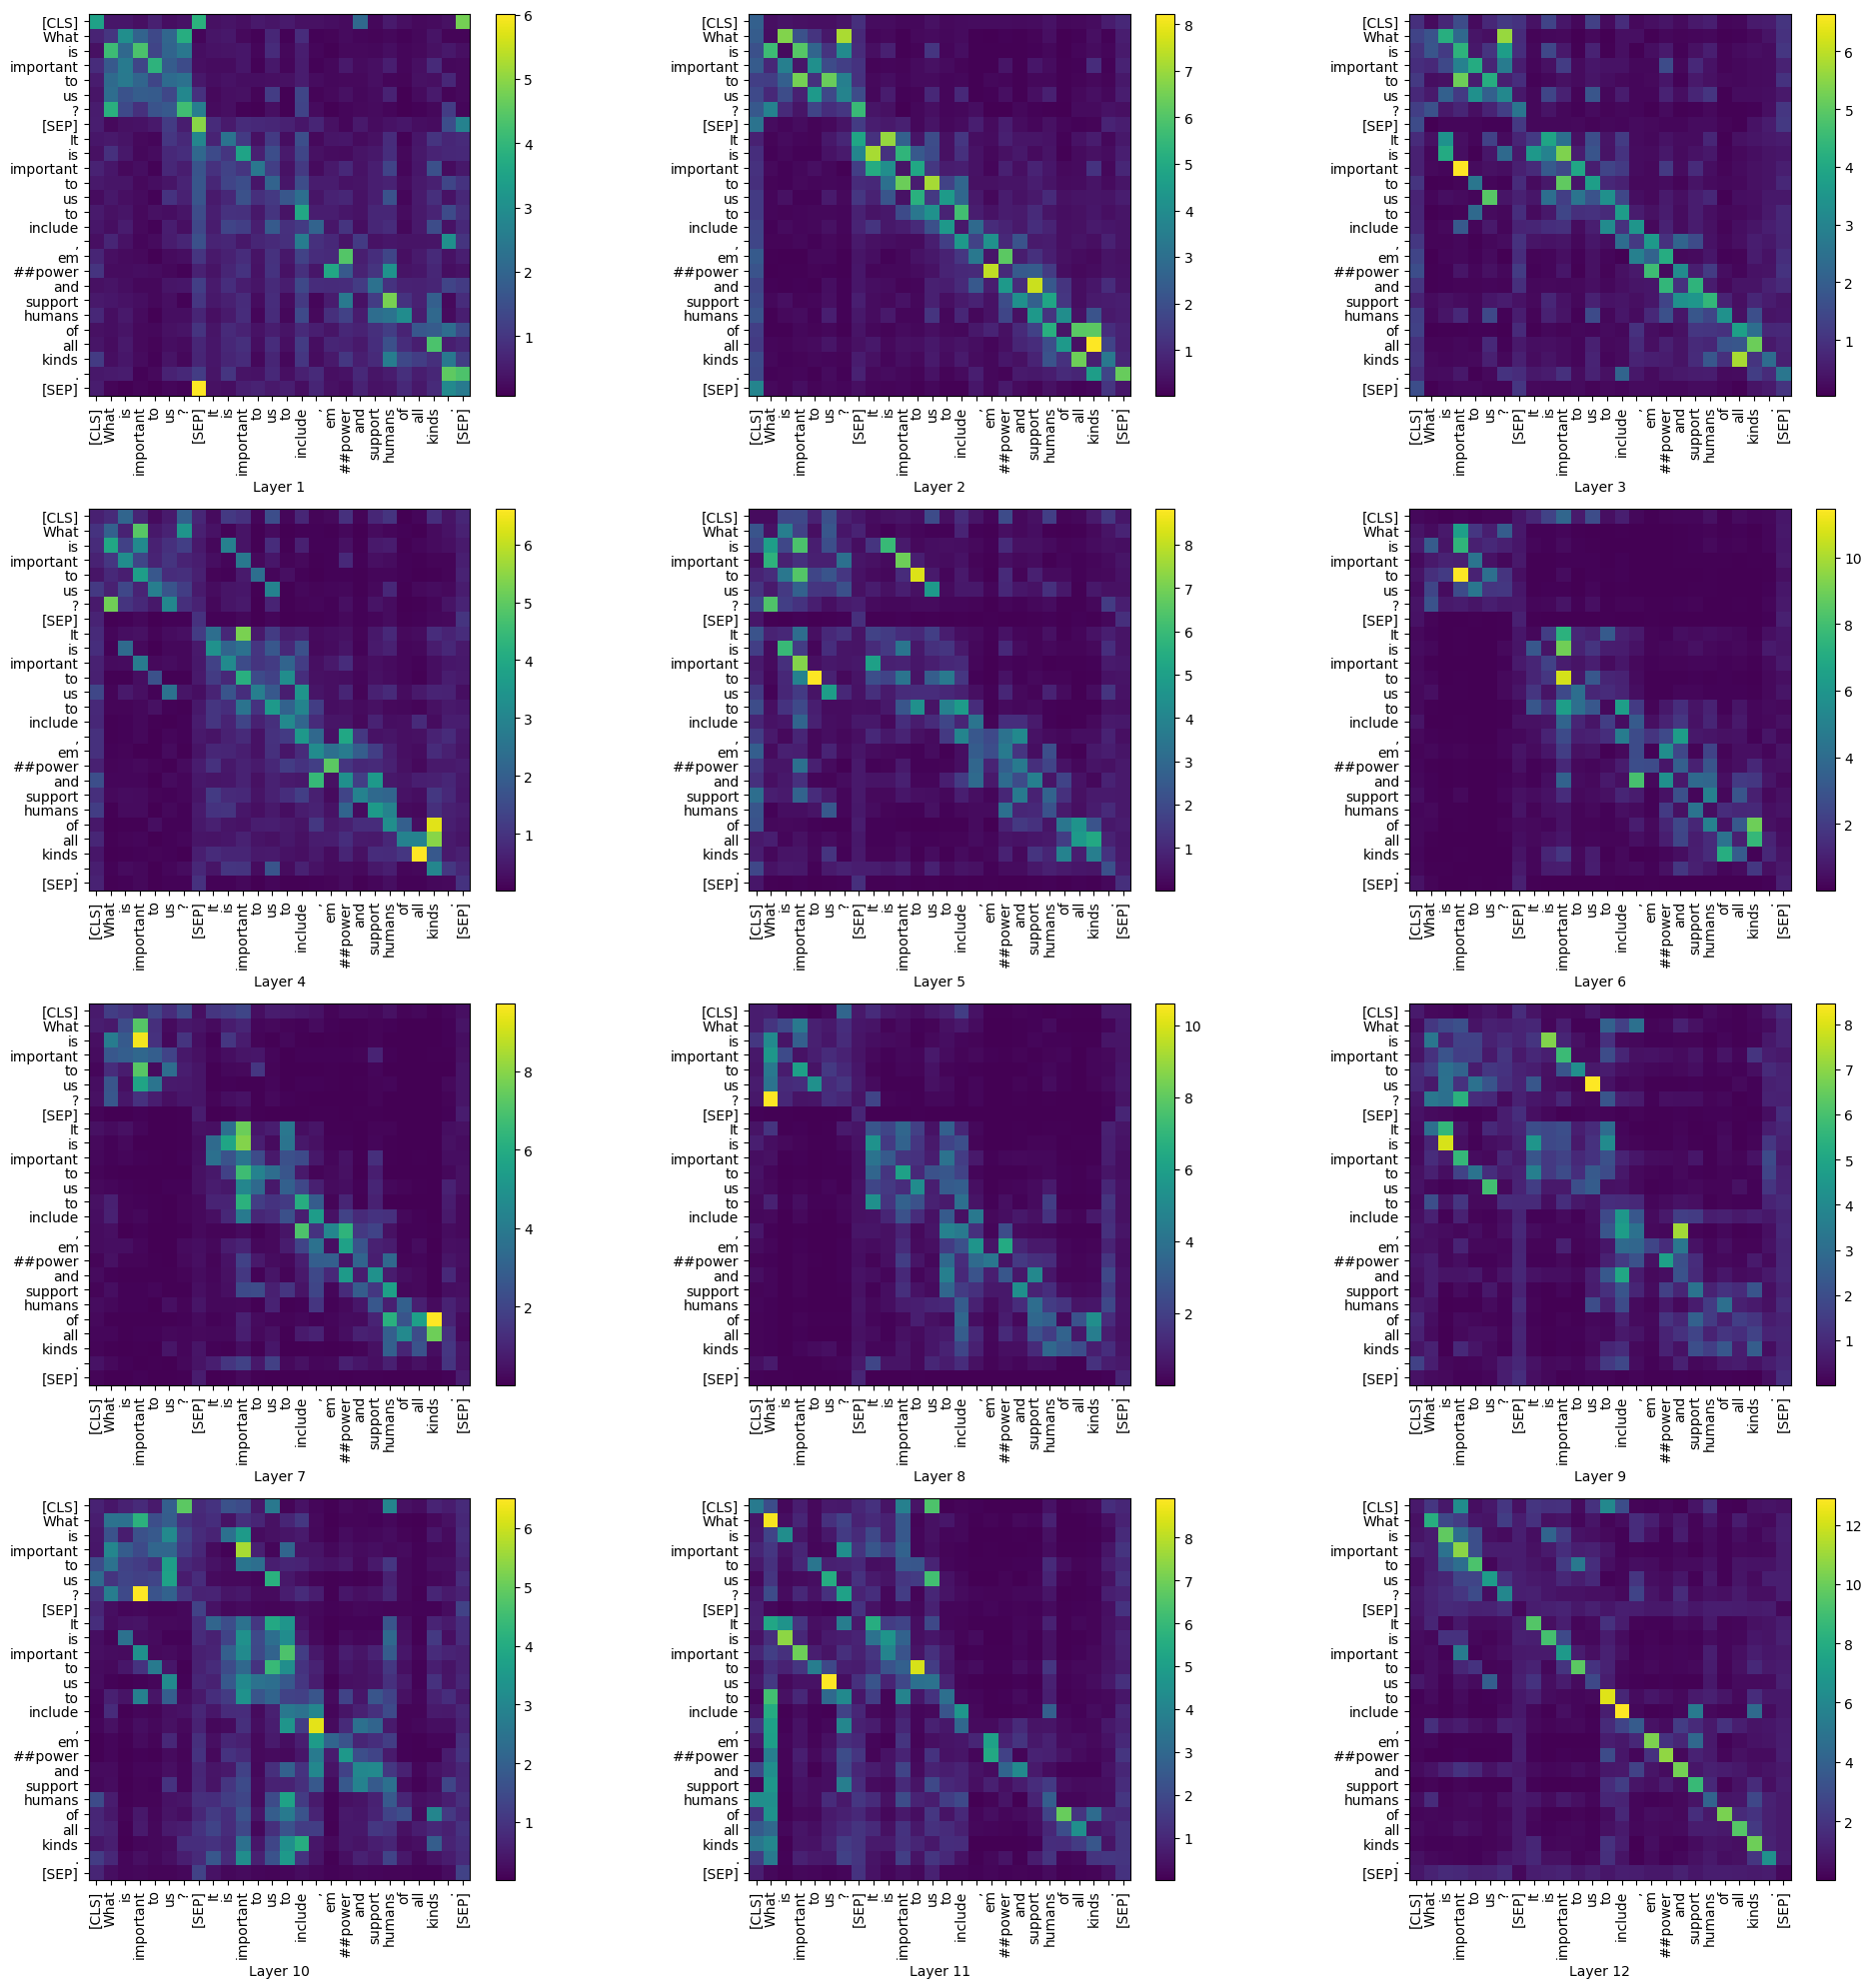

In [41]:
visualize_token2token_scores(summed_alpha_f_x_norm.squeeze().cpu().detach().numpy(), x_label_name='Layer')